# Previsione dell'affidabilità creditizia per il rilascio della carta di credito

Sei stato assunto dalla Pro National Bank come data scientist, il tuo primo incarico consiste nel realizzare un modello in grado di stimare l'affidabilità creditizia di un clienti, al fine di di aiutare il team dedicato a comprendere se accettare o meno la richiesta per il rilascio della carta di credito.

A tal fine ti vengono consegnati i dati anonimizzati di clienti che hanno già ottenuto la carta di credito e lo stato del loro debito mensile.


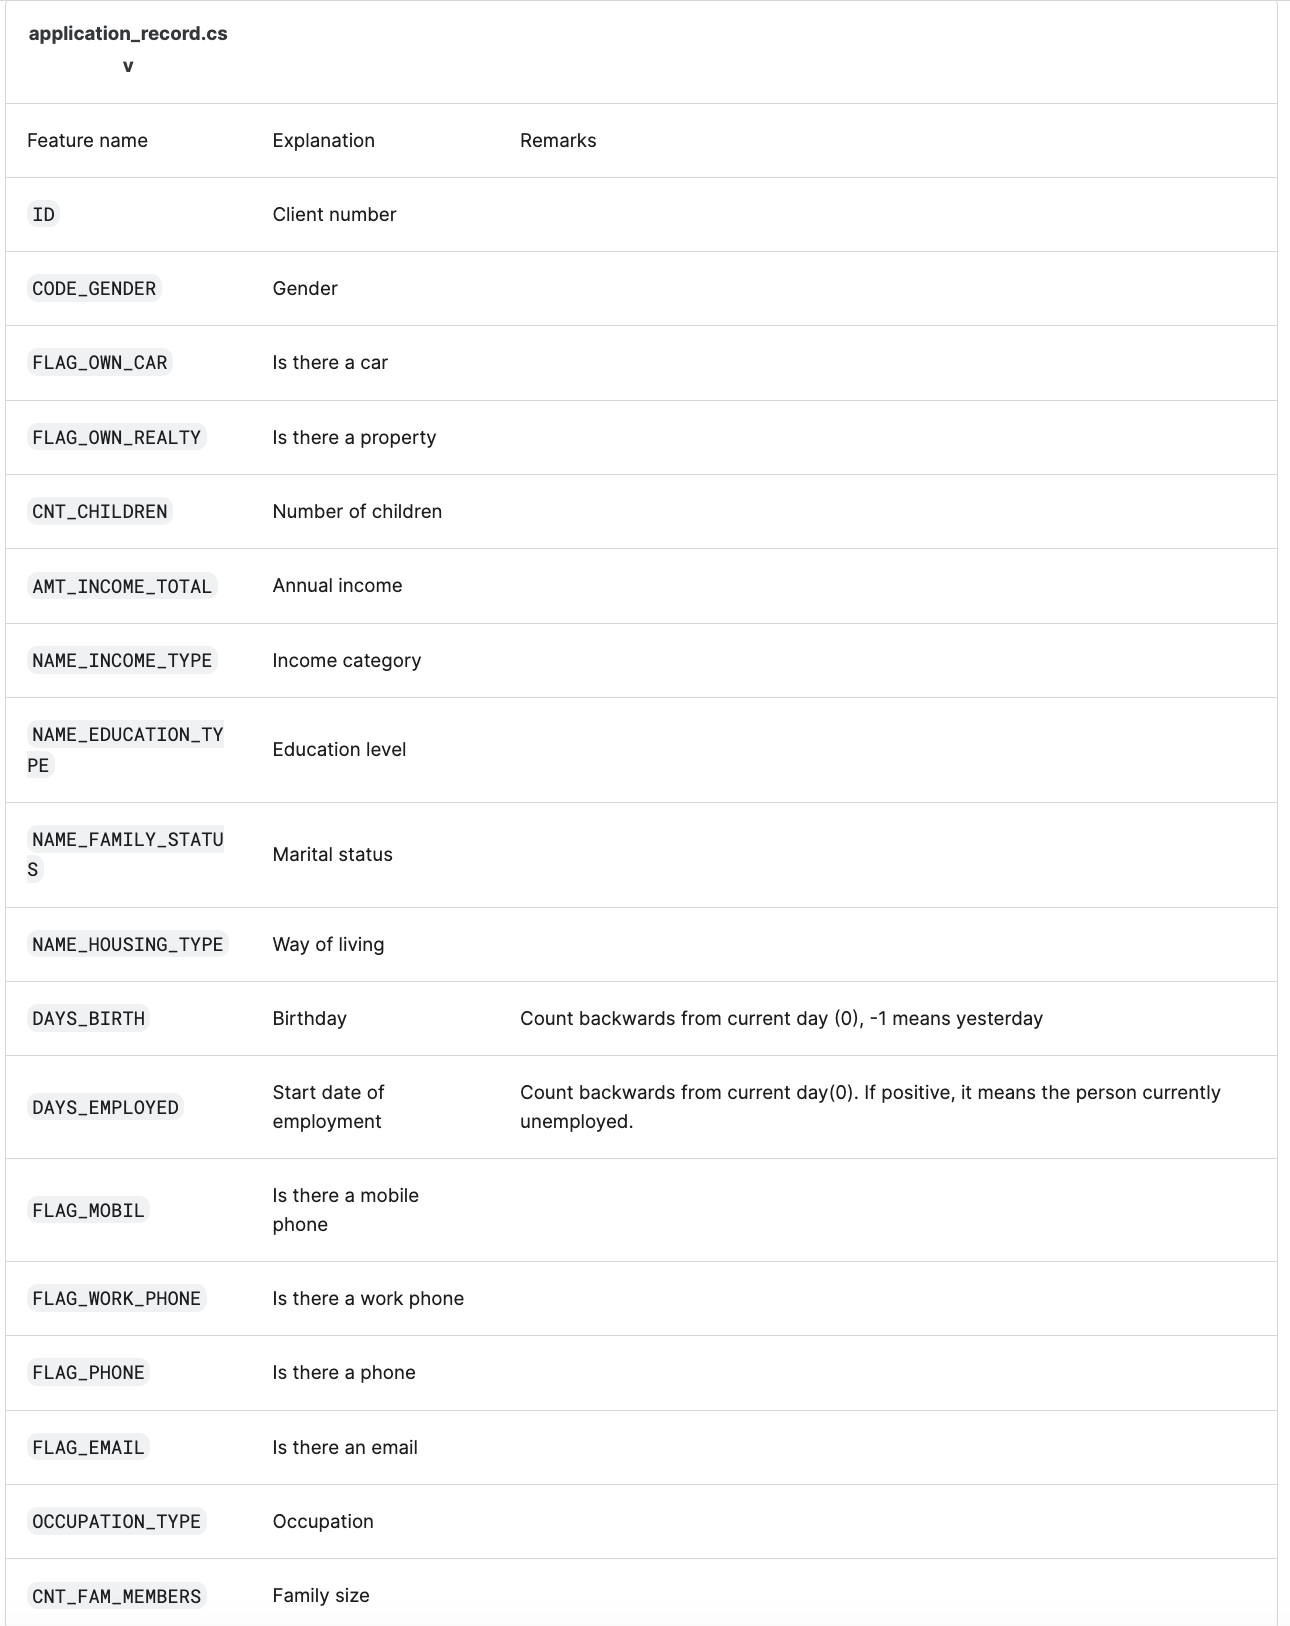



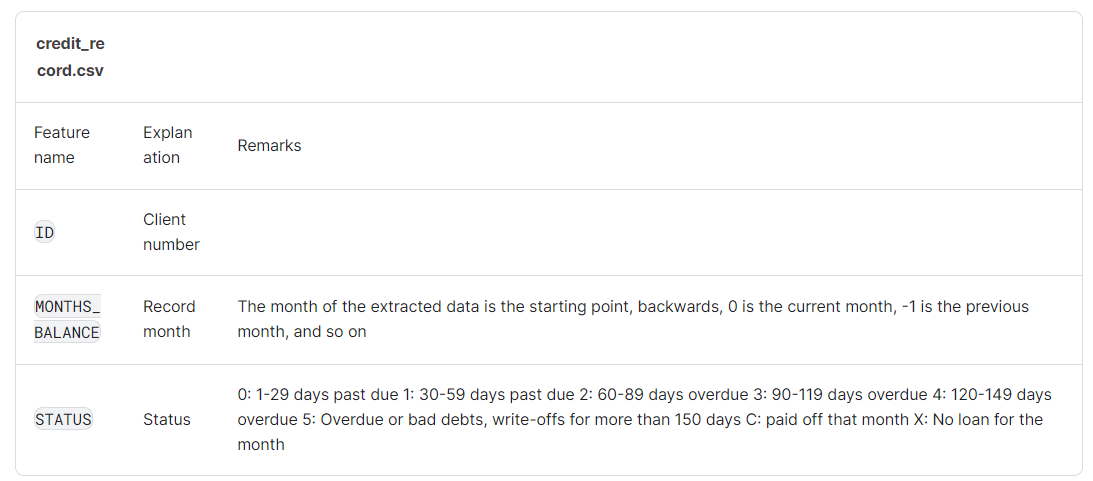

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
application = pd.read_csv('/Users/nico/Data science/ProfessionAI/ML/Credit/Approv/application_record.csv')
credit= pd.read_csv('/Users/nico/Data science/ProfessionAI/ML/Credit/Approv/credit_record.csv')

# EDA

## Application CSV

In [3]:
print(f'Df shape:{application.shape}')
application.head()
print('\n')
print(f'Df shape:{credit.shape}')
credit.head()

Df shape:(438557, 18)


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0




Df shape:(1048575, 3)


,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [4]:
# I'm looking for duplicated ID in Dataset and drop them
application['ID'].duplicated(keep='last').sum()
application = application.drop_duplicates(subset='ID',keep='last')
application.shape

47

(438510, 18)

In [5]:
#I'm looking for NaN in data frame
application.isna().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134187
CNT_FAM_MEMBERS             0
dtype: int64

In [6]:
application['OCCUPATION_TYPE'].value_counts(dropna=False)
# I call the Nan values as 'Not Specified'
application['OCCUPATION_TYPE'] = application['OCCUPATION_TYPE'].fillna('Not Specified',axis=0)
print(30*'---')
# And i print the new distribution of occupation tipe
application['OCCUPATION_TYPE'].value_counts()

NaN                      134187
Laborers                  78234
Core staff                43000
Sales staff               41096
Managers                  35483
Drivers                   26085
High skill tech staff     17287
Accountants               15982
Medicine staff            13520
Cooking staff              8074
Security staff             7993
Cleaning staff             5845
Private service staff      3456
Low-skill Laborers         2140
Secretaries                2044
Waiters/barmen staff       1665
Realty agents              1041
HR staff                    774
IT staff                    604
Name: OCCUPATION_TYPE, dtype: int64

------------------------------------------------------------------------------------------


Not Specified            134187
Laborers                  78234
Core staff                43000
Sales staff               41096
Managers                  35483
Drivers                   26085
High skill tech staff     17287
Accountants               15982
Medicine staff            13520
Cooking staff              8074
Security staff             7993
Cleaning staff             5845
Private service staff      3456
Low-skill Laborers         2140
Secretaries                2044
Waiters/barmen staff       1665
Realty agents              1041
HR staff                    774
IT staff                    604
Name: OCCUPATION_TYPE, dtype: int64

In [7]:
# Looking for how many applicant are unenployed
unenployed = [day for day in application['DAYS_EMPLOYED'] if day >=0]
unenployed_df = pd.DataFrame(unenployed)

print(f'In this dataset {len(unenployed_df)} ppl are unployed')
unenployed_df.describe()
# I change the value 365243 which represent unenployed days (1000 years??) with the value of 0
application['DAYS_EMPLOYED'].replace(365243,0,inplace=True)


In this dataset 75319 ppl are unployed


,0
count,75319.0
mean,365243.0
std,0.0
min,365243.0
25%,365243.0
50%,365243.0
75%,365243.0
max,365243.0


In [8]:
# After I change the values expressed in days in years
application['AGE']=round(application['DAYS_BIRTH']/-365.243,0)
application['YEARS_EMPLOYED'] = round(application['DAYS_EMPLOYED']/-365.243,0)


# And drop the columns with values in days
application = application.drop(['DAYS_EMPLOYED', 'DAYS_BIRTH'],axis=1)
application.shape

# Lastly I print some description of the two new columns
application['AGE'].describe()
application['AGE'].value_counts()
print(30*'---')
application['YEARS_EMPLOYED'].describe()
application['YEARS_EMPLOYED'].value_counts()

(438510, 18)

count    438510.000000
mean         43.803925
std          11.465598
min          21.000000
25%          34.000000
50%          43.000000
75%          53.000000
max          69.000000
Name: AGE, dtype: float64

39.0    13933
40.0    13269
42.0    13120
28.0    12889
38.0    12773
32.0    12759
37.0    12698
41.0    12654
43.0    12489
30.0    12385
36.0    12321
35.0    12215
44.0    12129
29.0    12035
33.0    11959
34.0    11953
31.0    11377
45.0    10675
54.0    10465
46.0    10449
47.0    10366
48.0    10066
53.0     9988
52.0     9875
60.0     9835
51.0     9769
57.0     9736
49.0     9601
55.0     9556
50.0     9538
58.0     9315
56.0     9201
59.0     9106
27.0     9083
61.0     8253
63.0     7760
62.0     7513
64.0     6902
65.0     5496
26.0     5389
25.0     4540
24.0     3661
23.0     3356
66.0     2459
67.0     1566
22.0     1075
68.0      882
69.0       46
21.0       30
Name: AGE, dtype: int64

------------------------------------------------------------------------------------------


count    438510.000000
mean          5.956076
std           6.574178
min          -0.000000
25%           1.000000
50%           4.000000
75%           8.000000
max          48.000000
Name: YEARS_EMPLOYED, dtype: float64

-0.0     86852
 1.0     42057
 2.0     37097
 3.0     36534
 4.0     31153
 5.0     28691
 6.0     23122
 7.0     22557
 8.0     20912
 9.0     16670
 10.0    14154
 11.0    10574
 12.0     9143
 13.0     8015
 15.0     7480
 14.0     7151
 16.0     3872
 17.0     3794
 19.0     3089
 20.0     3039
 18.0     2913
 21.0     2535
 22.0     2518
 23.0     1903
 24.0     1664
 25.0     1513
 28.0     1280
 27.0     1246
 26.0     1235
 29.0     1027
 31.0      744
 30.0      724
 32.0      587
 35.0      488
 33.0      482
 34.0      481
 36.0      238
 37.0      235
 38.0      186
 40.0      160
 41.0      127
 39.0      117
 43.0       61
 42.0       43
 44.0       20
 45.0       20
 48.0        6
 46.0        1
Name: YEARS_EMPLOYED, dtype: int64

In [9]:
# Looking for type of different variables
application.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 438510 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438510 non-null  int64  
 1   CODE_GENDER          438510 non-null  object 
 2   FLAG_OWN_CAR         438510 non-null  object 
 3   FLAG_OWN_REALTY      438510 non-null  object 
 4   CNT_CHILDREN         438510 non-null  int64  
 5   AMT_INCOME_TOTAL     438510 non-null  float64
 6   NAME_INCOME_TYPE     438510 non-null  object 
 7   NAME_EDUCATION_TYPE  438510 non-null  object 
 8   NAME_FAMILY_STATUS   438510 non-null  object 
 9   NAME_HOUSING_TYPE    438510 non-null  object 
 10  FLAG_MOBIL           438510 non-null  int64  
 11  FLAG_WORK_PHONE      438510 non-null  int64  
 12  FLAG_PHONE           438510 non-null  int64  
 13  FLAG_EMAIL           438510 non-null  int64  
 14  OCCUPATION_TYPE      438510 non-null  object 
 15  CNT_FAM_MEMBERS  

## Plots


In [14]:

plt.style.use('default')

array([[<AxesSubplot: title={'center': 'CNT_CHILDREN'}>,
        <AxesSubplot: title={'center': 'AMT_INCOME_TOTAL'}>,
        <AxesSubplot: title={'center': 'FLAG_MOBIL'}>],
       [<AxesSubplot: title={'center': 'FLAG_WORK_PHONE'}>,
        <AxesSubplot: title={'center': 'FLAG_PHONE'}>,
        <AxesSubplot: title={'center': 'FLAG_EMAIL'}>],
       [<AxesSubplot: title={'center': 'CNT_FAM_MEMBERS'}>,
        <AxesSubplot: title={'center': 'AGE'}>,
        <AxesSubplot: title={'center': 'YEARS_EMPLOYED'}>]], dtype=object)

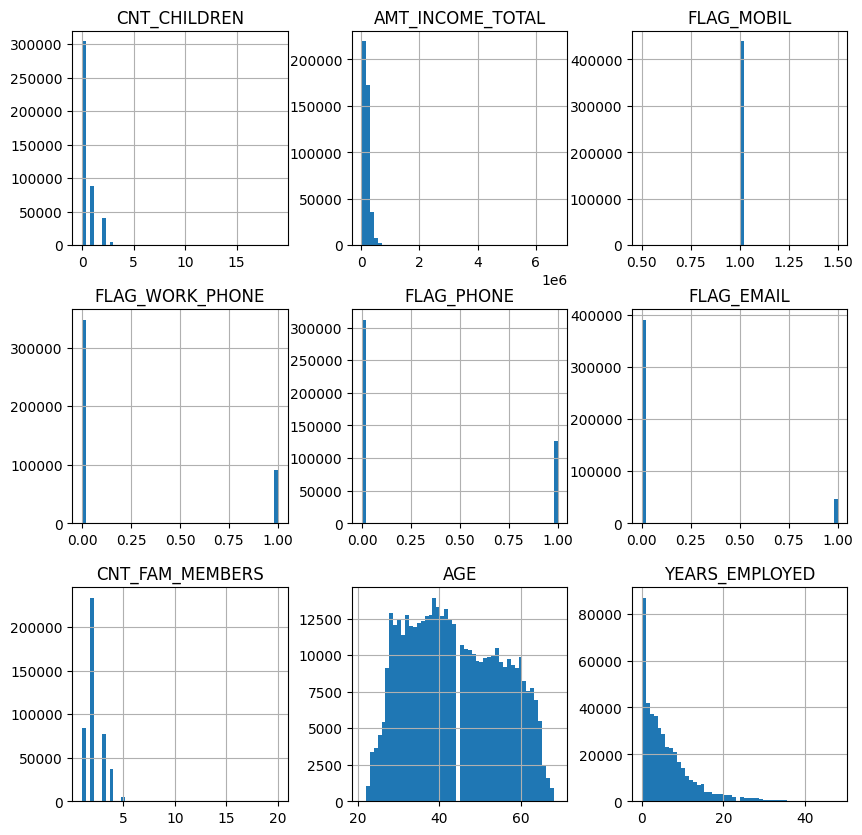

In [15]:
#Fistrly I do a speed plot with pandas just to see distribution of numeric variables
application.iloc[:,1:].hist(figsize=(10,10),bins=50)

<Figure size 800x800 with 0 Axes>

Text(0.0, 294412.0, '294412')

Text(1.0, 144098.0, '144098')

(array([0, 1]), [Text(0, 0, 'F'), Text(1, 0, 'M')])

Text(0.5, 1.0, 'CODE_GENDER')

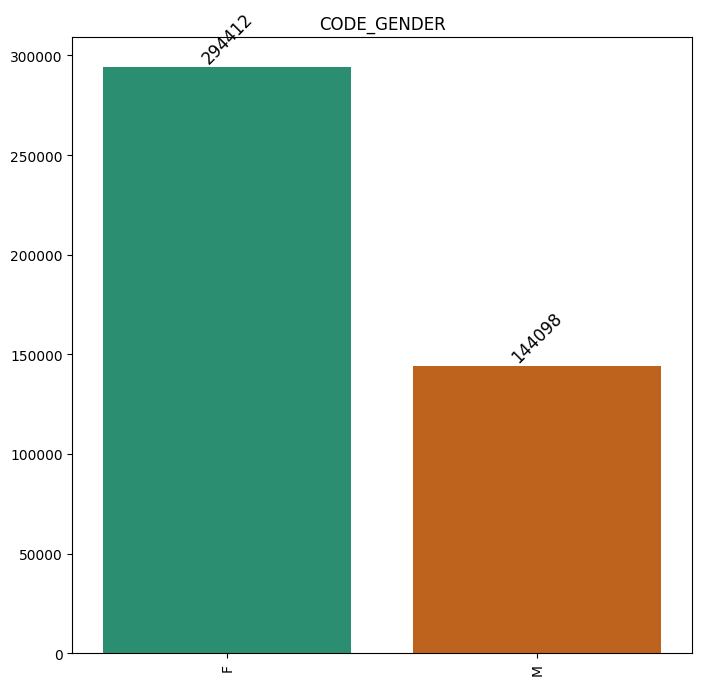

<Figure size 800x800 with 0 Axes>

Text(0.0, 391062.0, '391062')

Text(1.0, 47448.0, '47448')

(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

Text(0.5, 1.0, 'FLAG_EMAIL')

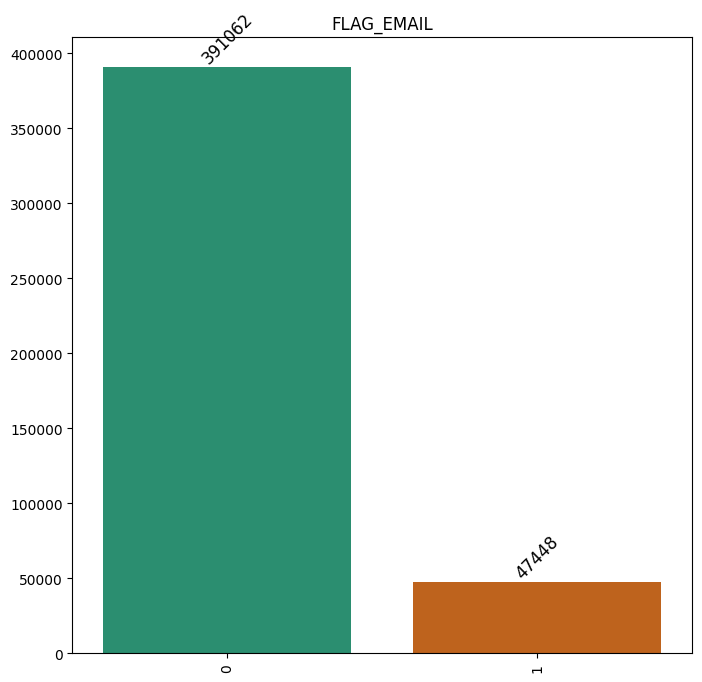

<Figure size 800x800 with 0 Axes>

Text(0.0, 275428.0, '275428')

Text(1.0, 163082.0, '163082')

(array([0, 1]), [Text(0, 0, 'N'), Text(1, 0, 'Y')])

Text(0.5, 1.0, 'FLAG_OWN_CAR')

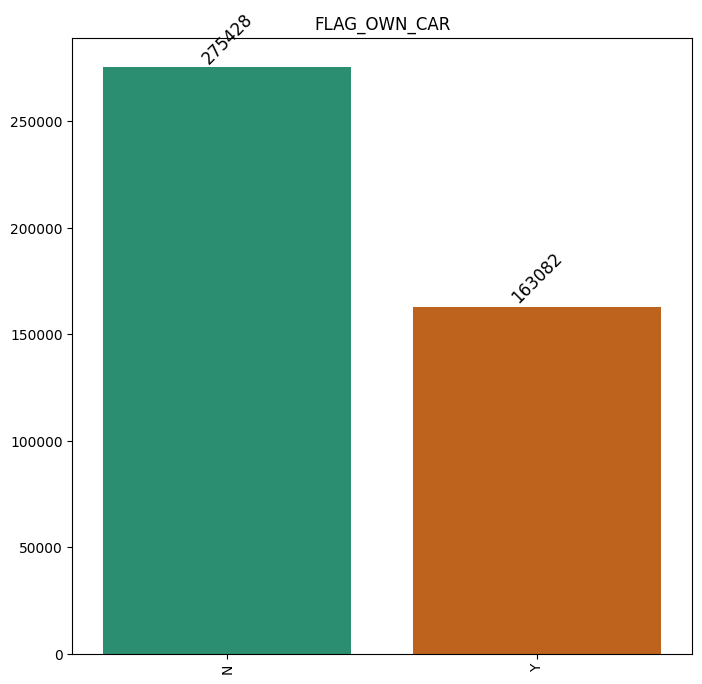

<Figure size 800x800 with 0 Axes>

Text(0.0, 304043.0, '304043')

Text(1.0, 134467.0, '134467')

(array([0, 1]), [Text(0, 0, 'Y'), Text(1, 0, 'N')])

Text(0.5, 1.0, 'FLAG_OWN_REALTY')

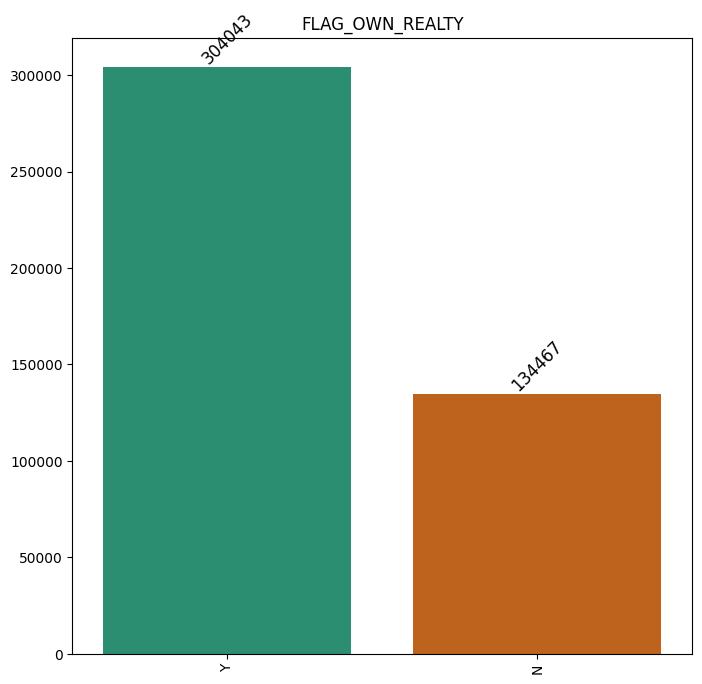

<Figure size 800x800 with 0 Axes>

Text(0.0, 312323.0, '312323')

Text(1.0, 126187.0, '126187')

(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

Text(0.5, 1.0, 'FLAG_PHONE')

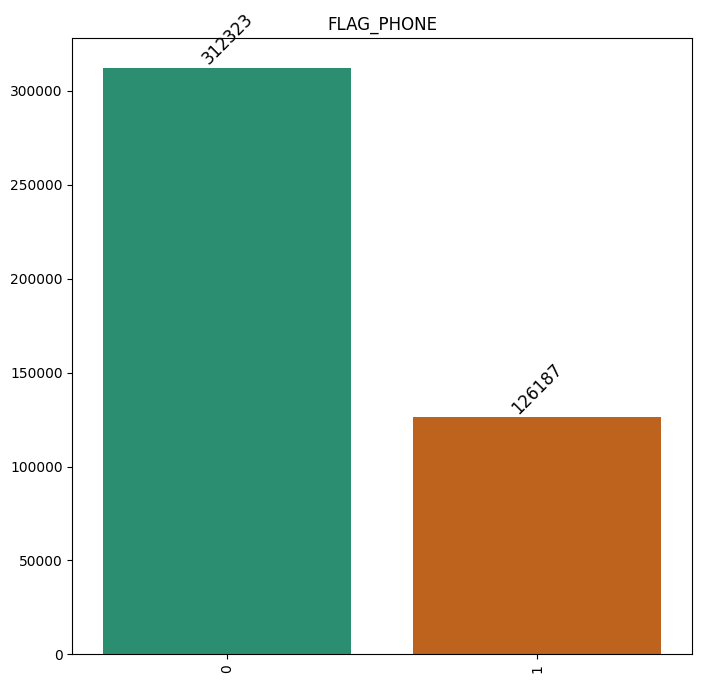

<Figure size 800x800 with 0 Axes>

Text(0.0, 348118.0, '348118')

Text(1.0, 90392.0, '90392')

(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

Text(0.5, 1.0, 'FLAG_WORK_PHONE')

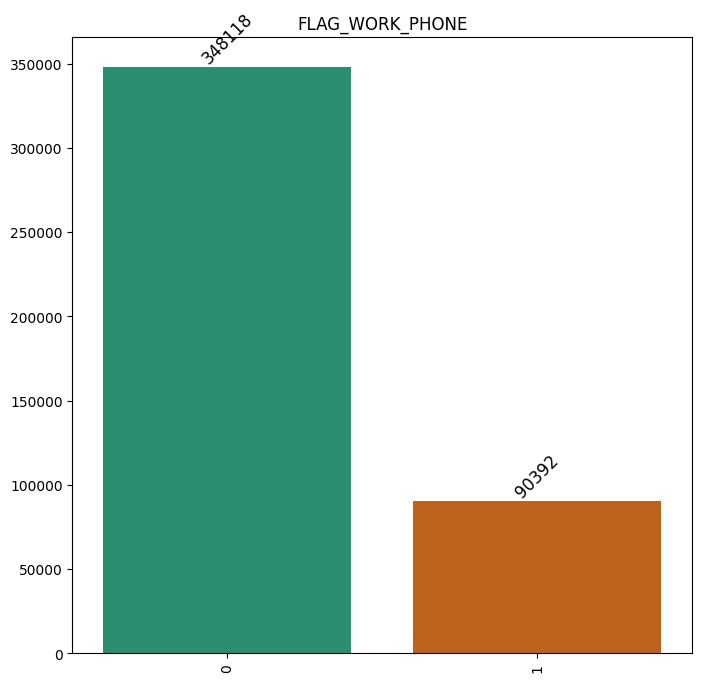

<Figure size 800x800 with 0 Axes>

Text(0.0, 301789.0, '301789')

Text(1.0, 117509.0, '117509')

Text(2.0, 14849.0, '14849')

Text(3.0, 4051.0, '4051')

Text(4.0, 312.0, '312')

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Secondary / secondary special'),
  Text(1, 0, 'Higher education'),
  Text(2, 0, 'Incomplete higher'),
  Text(3, 0, 'Lower secondary'),
  Text(4, 0, 'Academic degree')])

Text(0.5, 1.0, 'NAME_EDUCATION_TYPE')

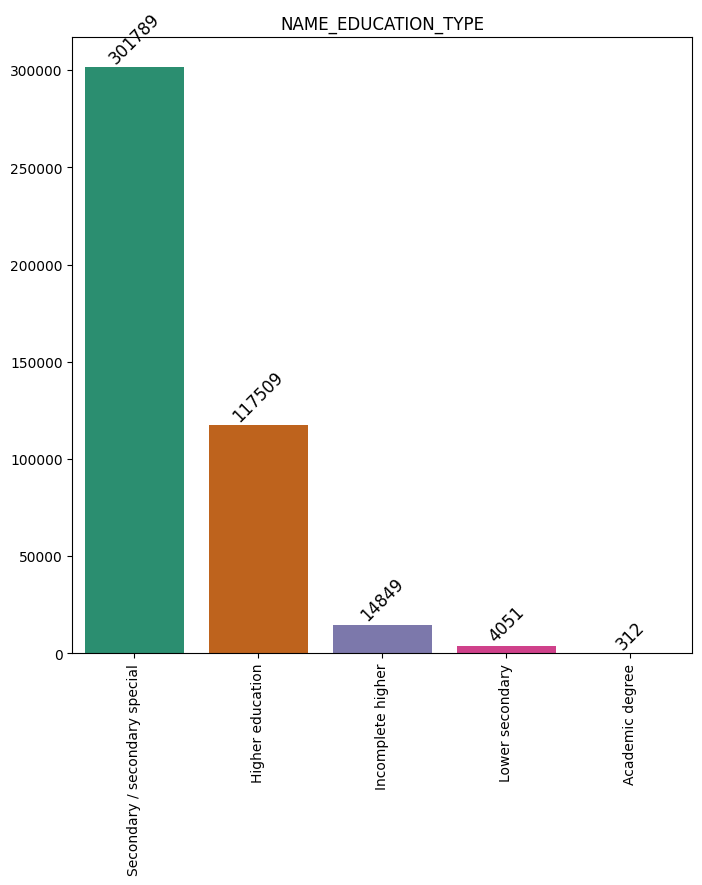

<Figure size 800x800 with 0 Axes>

Text(0.0, 299798.0, '299798')

Text(1.0, 55268.0, '55268')

Text(2.0, 36524.0, '36524')

Text(3.0, 27249.0, '27249')

Text(4.0, 19671.0, '19671')

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Married'),
  Text(1, 0, 'Single / not married'),
  Text(2, 0, 'Civil marriage'),
  Text(3, 0, 'Separated'),
  Text(4, 0, 'Widow')])

Text(0.5, 1.0, 'NAME_FAMILY_STATUS')

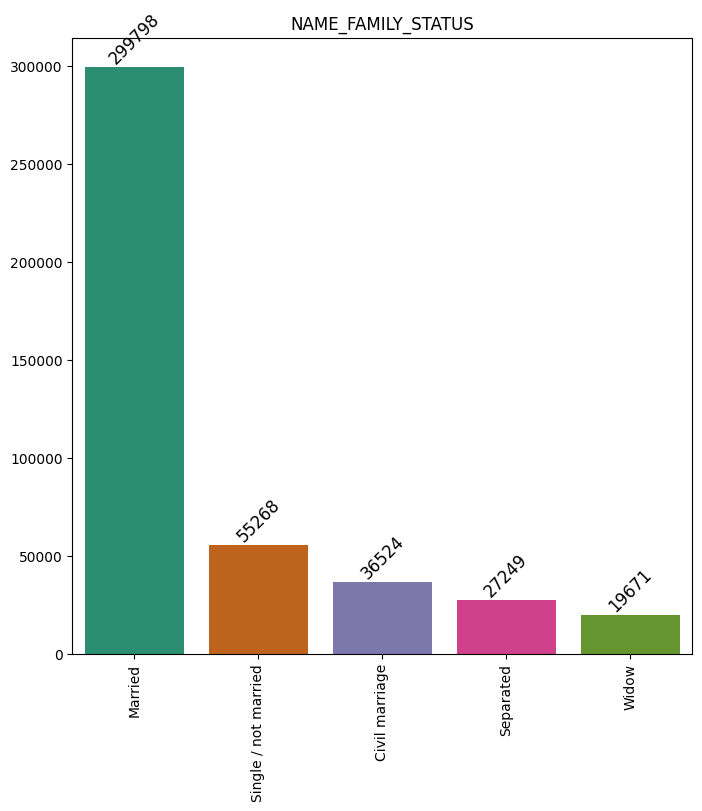

<Figure size 800x800 with 0 Axes>

Text(0.0, 393788.0, '393788')

Text(1.0, 19074.0, '19074')

Text(2.0, 14213.0, '14213')

Text(3.0, 5974.0, '5974')

Text(4.0, 3922.0, '3922')

Text(5.0, 1539.0, '1539')

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'House / apartment'),
  Text(1, 0, 'With parents'),
  Text(2, 0, 'Municipal apartment'),
  Text(3, 0, 'Rented apartment'),
  Text(4, 0, 'Office apartment'),
  Text(5, 0, 'Co-op apartment')])

Text(0.5, 1.0, 'NAME_HOUSING_TYPE')

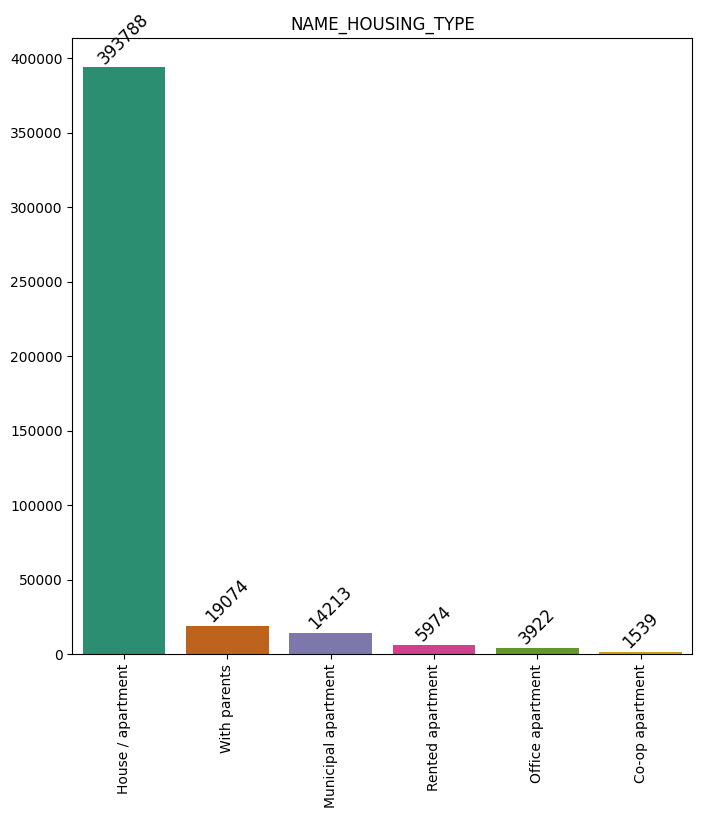

<Figure size 800x800 with 0 Axes>

Text(0.0, 226087.0, '226087')

Text(1.0, 100739.0, '100739')

Text(2.0, 75483.0, '75483')

Text(3.0, 36184.0, '36184')

Text(4.0, 17.0, '17')

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Working'),
  Text(1, 0, 'Commercial associate'),
  Text(2, 0, 'Pensioner'),
  Text(3, 0, 'State servant'),
  Text(4, 0, 'Student')])

Text(0.5, 1.0, 'NAME_INCOME_TYPE')

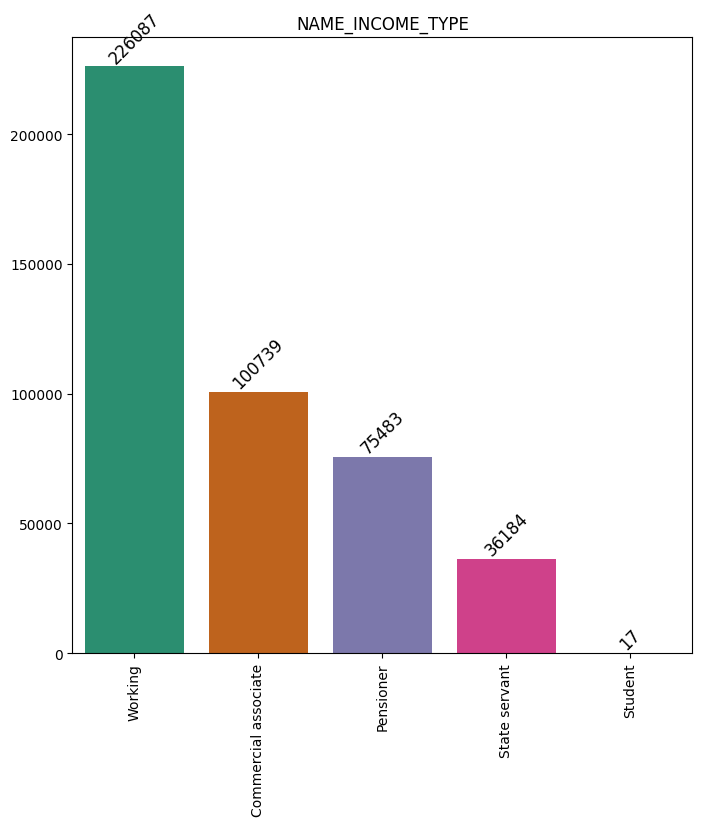

<Figure size 800x800 with 0 Axes>

Text(0.0, 134187.0, '134187')

Text(1.0, 78234.0, '78234')

Text(2.0, 43000.0, '43000')

Text(3.0, 41096.0, '41096')

Text(4.0, 35483.0, '35483')

Text(5.0, 26085.0, '26085')

Text(6.0, 17287.0, '17287')

Text(7.0, 15982.0, '15982')

Text(8.0, 13520.0, '13520')

Text(9.0, 8074.0, '8074')

Text(10.0, 7993.0, '7993')

Text(11.0, 5845.0, '5845')

Text(12.0, 3456.0, '3456')

Text(13.0, 2140.0, '2140')

Text(14.0, 2044.0, '2044')

Text(15.0, 1665.0, '1665')

Text(16.0, 1041.0, '1041')

Text(17.0, 774.0, '774')

Text(18.0, 604.0, '604')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 [Text(0, 0, 'Not Specified'),
  Text(1, 0, 'Laborers'),
  Text(2, 0, 'Core staff'),
  Text(3, 0, 'Sales staff'),
  Text(4, 0, 'Managers'),
  Text(5, 0, 'Drivers'),
  Text(6, 0, 'High skill tech staff'),
  Text(7, 0, 'Accountants'),
  Text(8, 0, 'Medicine staff'),
  Text(9, 0, 'Cooking staff'),
  Text(10, 0, 'Security staff'),
  Text(11, 0, 'Cleaning staff'),
  Text(12, 0, 'Private service staff'),
  Text(13, 0, 'Low-skill Laborers'),
  Text(14, 0, 'Secretaries'),
  Text(15, 0, 'Waiters/barmen staff'),
  Text(16, 0, 'Realty agents'),
  Text(17, 0, 'HR staff'),
  Text(18, 0, 'IT staff')])

Text(0.5, 1.0, 'OCCUPATION_TYPE')

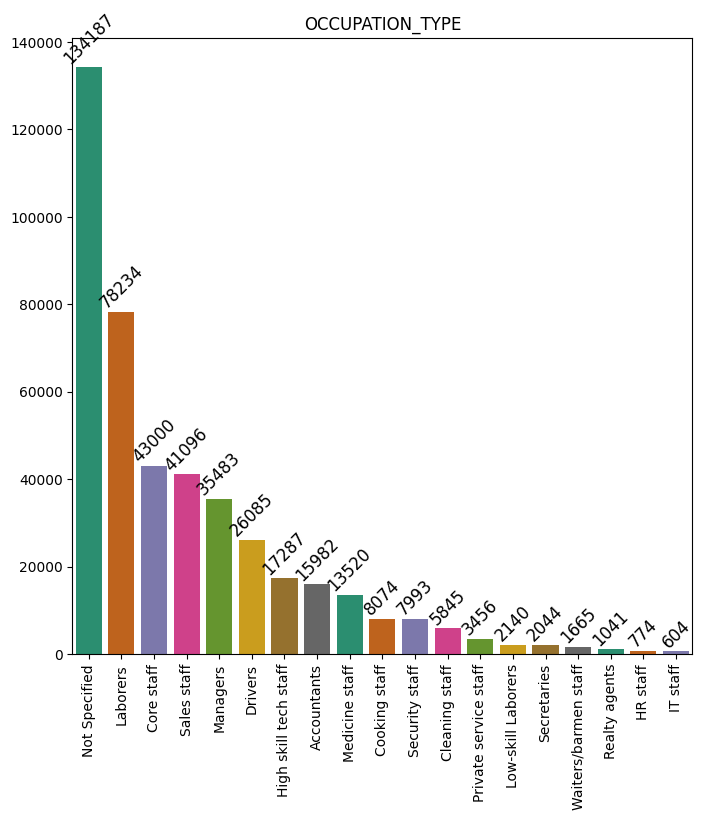

In [16]:
# Secondly I plot categorical variables with sns 
object_col = application.select_dtypes(include = ['object'])
object_col = object_col + application[['FLAG_WORK_PHONE','FLAG_PHONE','FLAG_EMAIL']]
for col in object_col.columns:

    palette = sns.color_palette('Dark2')
    plt.figure(figsize=(8, 8))
    ax = sns.barplot(x=application[col].value_counts().index,
            y=application[col].value_counts().values,
            palette=palette)
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width() / 2., p.get_height(), '%d' % int(p.get_height()),
                fontsize=12, color='black', ha='center', va='bottom',rotation=45)
    plt.xticks(rotation=90)
    plt.title(col)

    plt.show()





<Figure size 1000x1000 with 0 Axes>

<AxesSubplot: ylabel='CNT_CHILDREN'>

(array([0]), [Text(0, 0, '')])

Text(0.5, 1.0, 'CNT_CHILDREN')

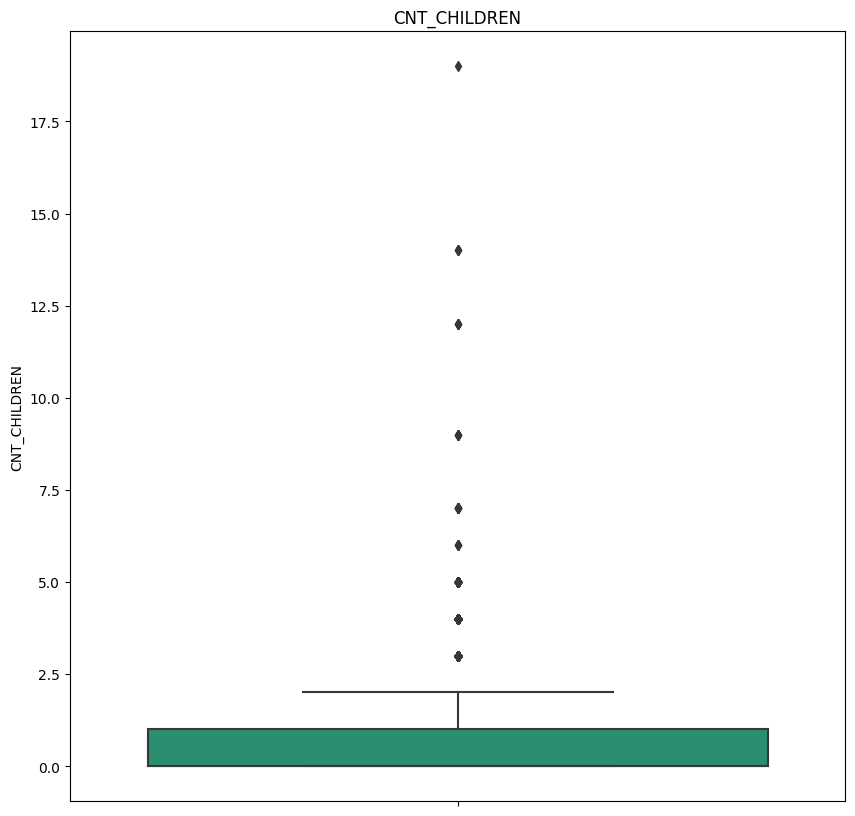

<Figure size 1000x1000 with 0 Axes>

<AxesSubplot: ylabel='AMT_INCOME_TOTAL'>

(array([0]), [Text(0, 0, '')])

Text(0.5, 1.0, 'AMT_INCOME_TOTAL')

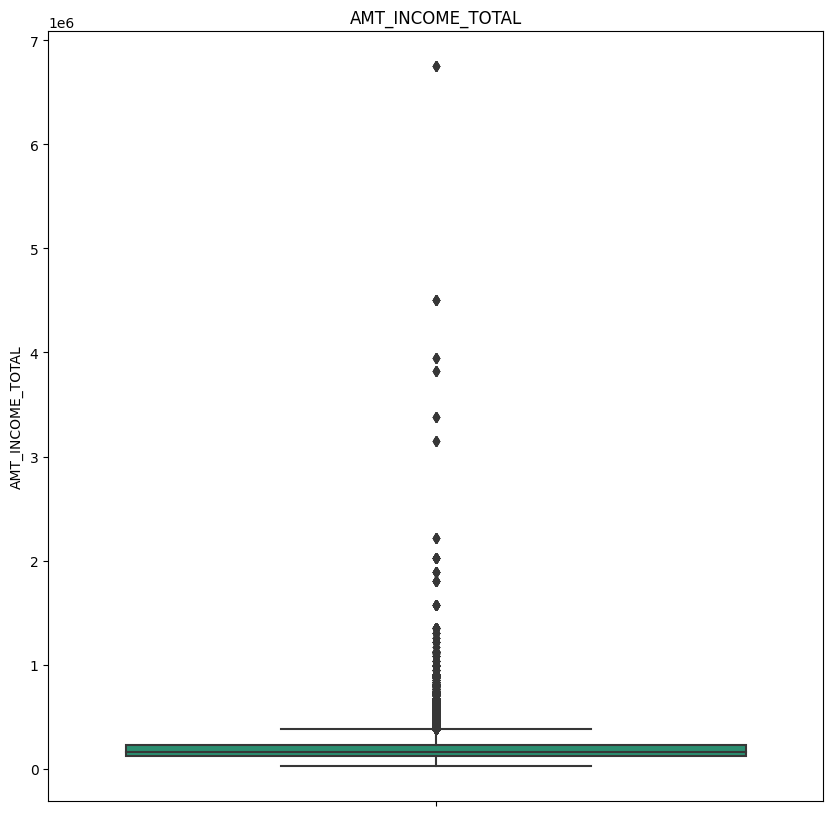

<Figure size 1000x1000 with 0 Axes>

<AxesSubplot: ylabel='CNT_FAM_MEMBERS'>

(array([0]), [Text(0, 0, '')])

Text(0.5, 1.0, 'CNT_FAM_MEMBERS')

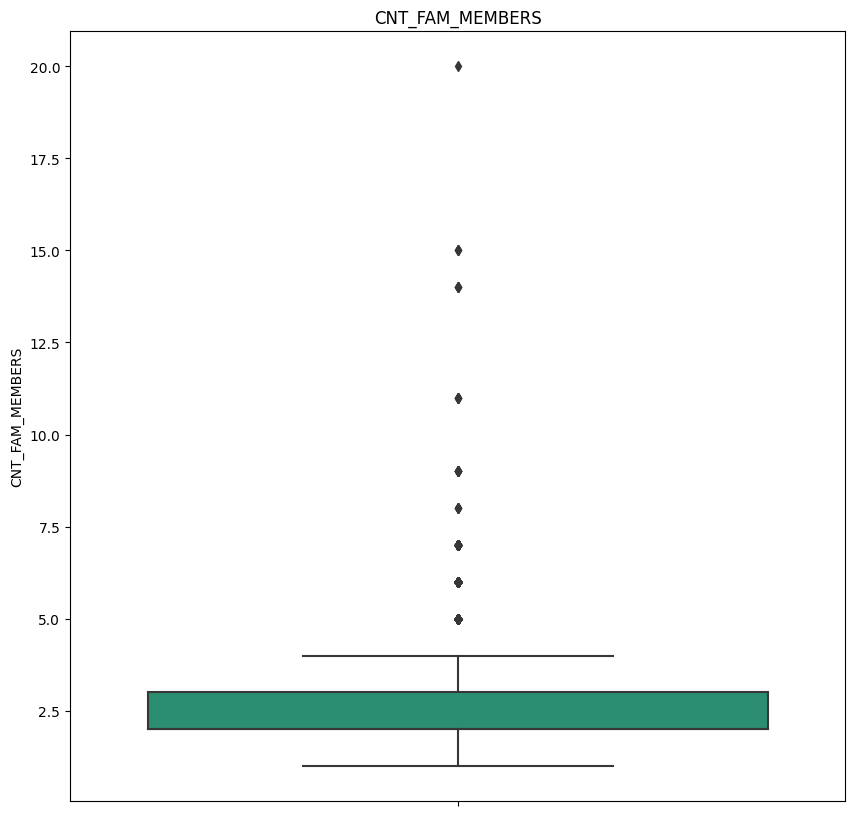

<Figure size 1000x1000 with 0 Axes>

<AxesSubplot: ylabel='AGE'>

(array([0]), [Text(0, 0, '')])

Text(0.5, 1.0, 'AGE')

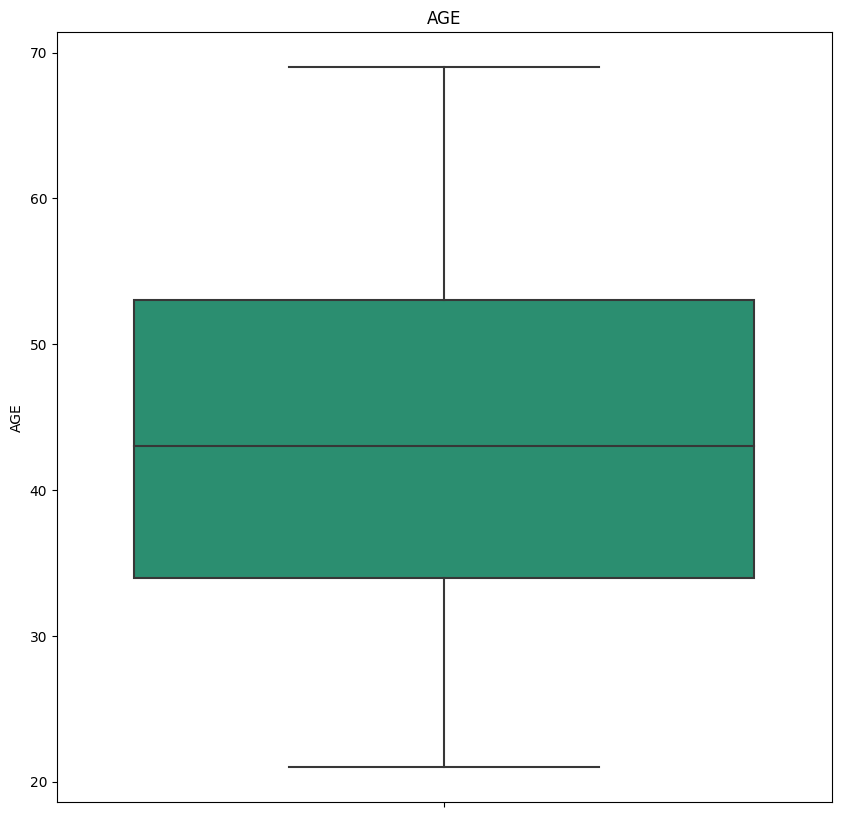

<Figure size 1000x1000 with 0 Axes>

<AxesSubplot: ylabel='YEARS_EMPLOYED'>

(array([0]), [Text(0, 0, '')])

Text(0.5, 1.0, 'YEARS_EMPLOYED')

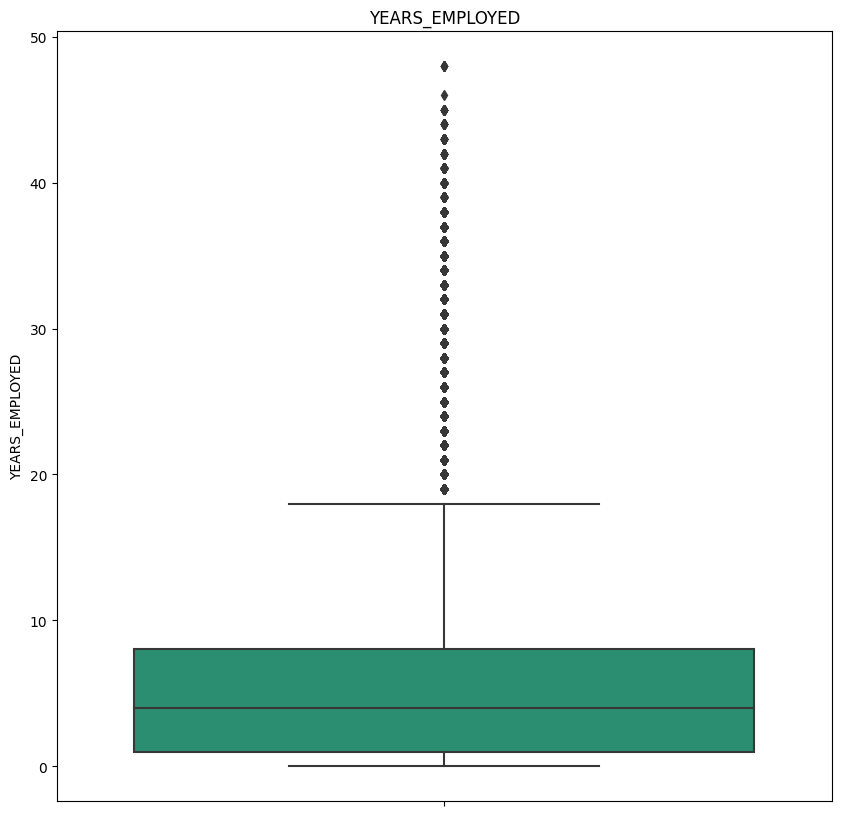

In [17]:
# I plot numerical features with boxplot in sns
numerical_cols =  application.select_dtypes(include = ['int64','float64'])
numerical_cols = numerical_cols.drop(['FLAG_WORK_PHONE','FLAG_PHONE','FLAG_EMAIL','FLAG_MOBIL'],axis=1)

for col in numerical_cols:
  if col != 'ID':
      palette = sns.color_palette('Dark2')
      plt.figure(figsize=(10, 10))

      sns.boxplot(application,
              y=application[col],
              palette=palette)
      plt.xticks(rotation=90)
      plt.title(col)

      plt.show()

<AxesSubplot: ylabel='CNT_CHILDREN'>

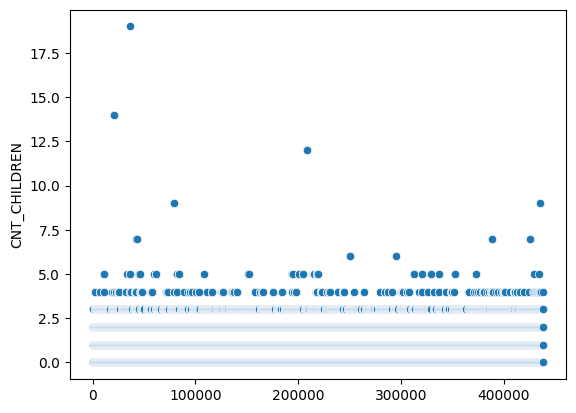

<AxesSubplot: ylabel='AMT_INCOME_TOTAL'>

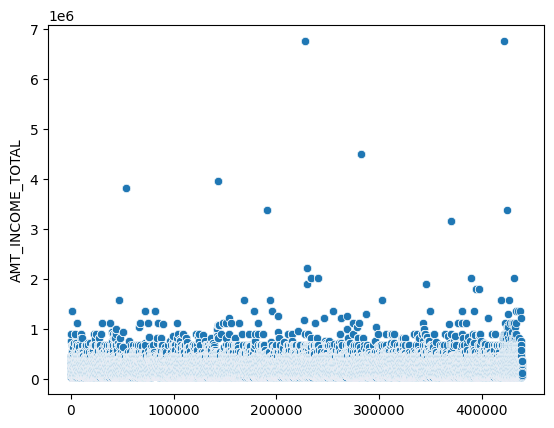

<AxesSubplot: ylabel='CNT_FAM_MEMBERS'>

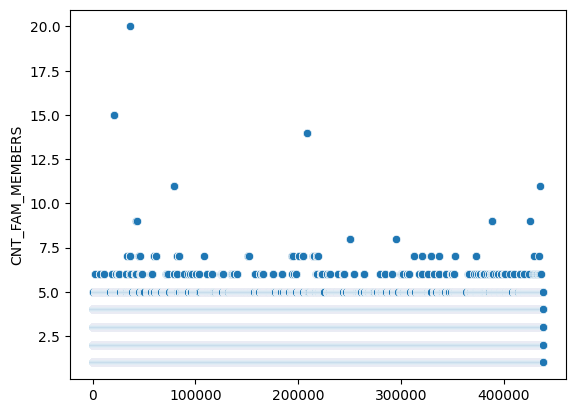

In [18]:
#I noticed from the scatterplots that there are outliers in the data 'CNT_CHILDREN, 'AMT_INCOME_TOTAL' 
#and 'CNT_FAM_MEMBERS' and I observe them through a scatter plot
outliers = ['CNT_CHILDREN','AMT_INCOME_TOTAL', 'CNT_FAM_MEMBERS']

for col in outliers:
  sns.scatterplot(application[col],
                  palette=palette)
  plt.show()

As imagined you can see from the scatterplot that there are data from households with more than 18 children, salaries greater than 6mln per year, and households with more than 20 people.
So I've decided to remove this outliers with z-scores:
- Z-score is a measure of how many standard deviations an element is from the mean. I remove outliers by removing data that have a Z-score greater than 3

<AxesSubplot: ylabel='CNT_CHILDREN'>

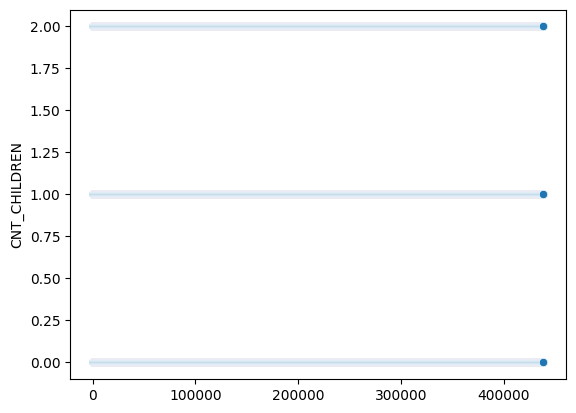

<AxesSubplot: ylabel='AMT_INCOME_TOTAL'>

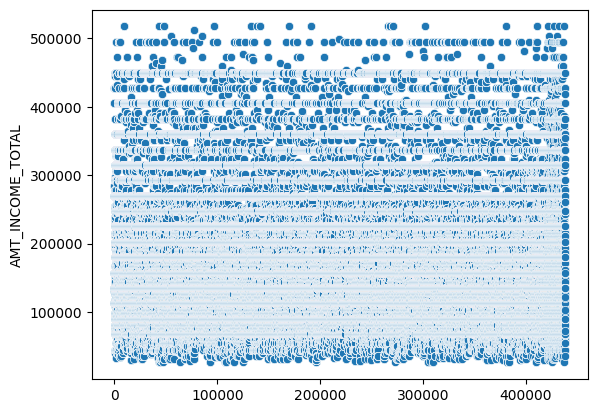

<AxesSubplot: ylabel='CNT_FAM_MEMBERS'>

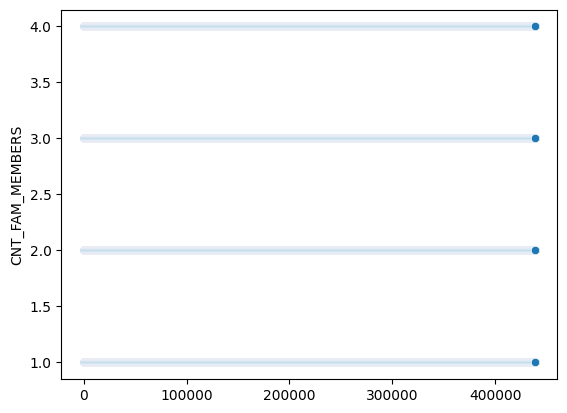

In [19]:
application = application[(np.abs(stats.zscore(application[outliers])) < 3).all(axis=1)]
outliers = ['CNT_CHILDREN','AMT_INCOME_TOTAL', 'CNT_FAM_MEMBERS']

for col in outliers:
  sns.scatterplot(application[col],
                  palette=palette)
  plt.show()

<Figure size 1000x600 with 0 Axes>

Text(0.5, 0, 'Income')

Text(0, 0.5, 'Frequency')

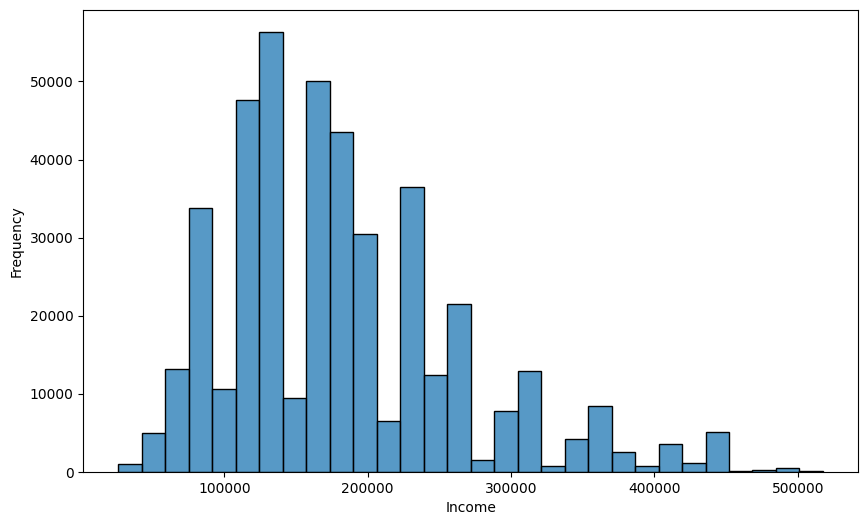

In [20]:
# I plot hist of annual income
plt.figure(figsize=(10, 6))
palette = sns.color_palette('Dark2')
ax = sns.histplot(data=application['AMT_INCOME_TOTAL'], bins=30,
                   edgecolor='black',palette=palette)
ax.set_xlabel('Income')
ax.set_ylabel('Frequency')
plt.show()


## Multivariate analysis
I plot some hist based on: 
- x_axis = categorical variables
- y_axis = numerical varibles
- hue = gender 

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Higher education'),
  Text(1, 0, 'Secondary / secondary special'),
  Text(2, 0, 'Incomplete higher'),
  Text(3, 0, 'Lower secondary'),
  Text(4, 0, 'Academic degree')])

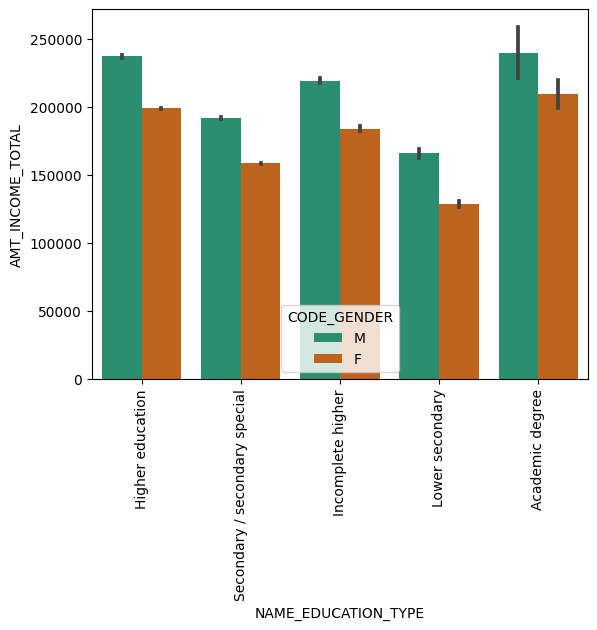

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Civil marriage'),
  Text(1, 0, 'Married'),
  Text(2, 0, 'Single / not married'),
  Text(3, 0, 'Separated'),
  Text(4, 0, 'Widow')])

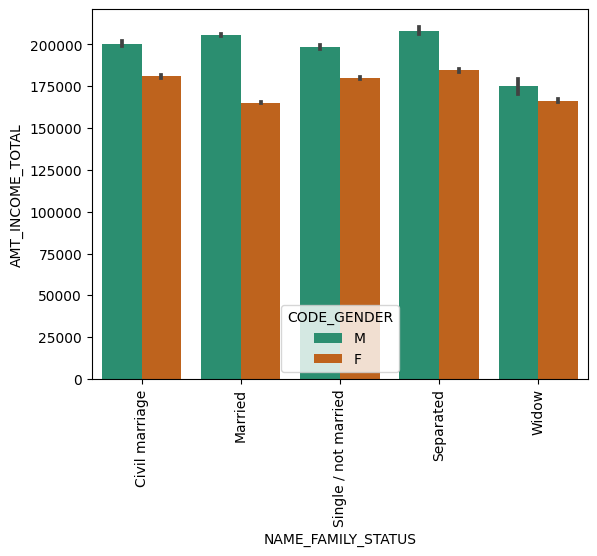

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Rented apartment'),
  Text(1, 0, 'House / apartment'),
  Text(2, 0, 'Municipal apartment'),
  Text(3, 0, 'With parents'),
  Text(4, 0, 'Co-op apartment'),
  Text(5, 0, 'Office apartment')])

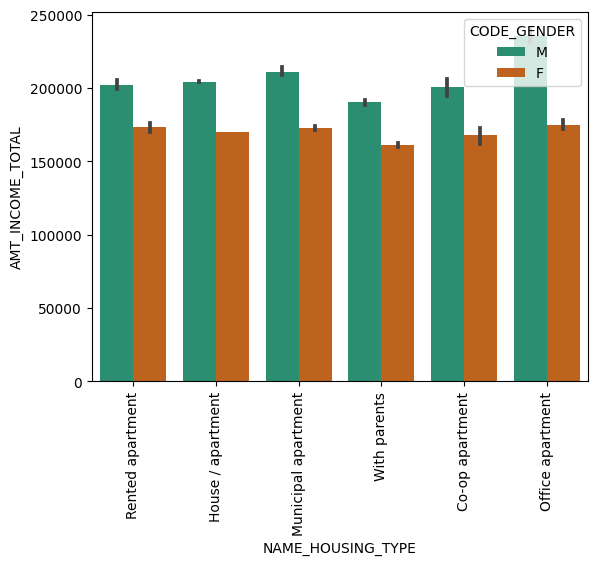

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Working'),
  Text(1, 0, 'Commercial associate'),
  Text(2, 0, 'Pensioner'),
  Text(3, 0, 'State servant'),
  Text(4, 0, 'Student')])

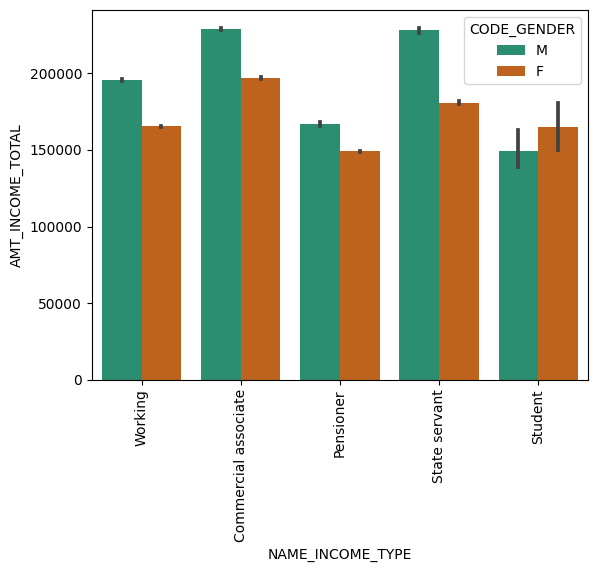

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 [Text(0, 0, 'Not Specified'),
  Text(1, 0, 'Security staff'),
  Text(2, 0, 'Sales staff'),
  Text(3, 0, 'Accountants'),
  Text(4, 0, 'Laborers'),
  Text(5, 0, 'Managers'),
  Text(6, 0, 'Drivers'),
  Text(7, 0, 'Core staff'),
  Text(8, 0, 'High skill tech staff'),
  Text(9, 0, 'Cleaning staff'),
  Text(10, 0, 'Private service staff'),
  Text(11, 0, 'Cooking staff'),
  Text(12, 0, 'Low-skill Laborers'),
  Text(13, 0, 'Medicine staff'),
  Text(14, 0, 'Secretaries'),
  Text(15, 0, 'Waiters/barmen staff'),
  Text(16, 0, 'HR staff'),
  Text(17, 0, 'Realty agents'),
  Text(18, 0, 'IT staff')])

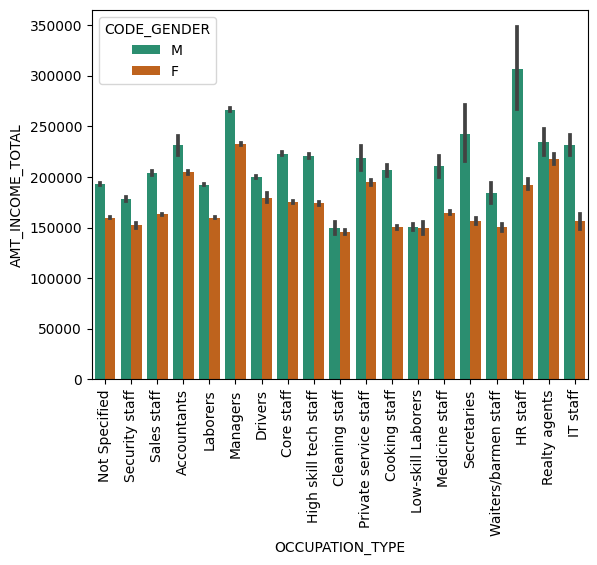

In [21]:
for col in object_col.drop(['FLAG_EMAIL', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'FLAG_PHONE', 'FLAG_WORK_PHONE'],axis=1).columns:
    if col != 'CODE_GENDER':
        palette = sns.color_palette('Dark2')
        ax = sns.barplot(data = application, 
                         x= col,
                         y='AMT_INCOME_TOTAL',
                         hue = 'CODE_GENDER',
                         palette=palette)
        
        plt.xticks(rotation=90)

        plt.show()

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Higher education'),
  Text(1, 0, 'Secondary / secondary special'),
  Text(2, 0, 'Incomplete higher'),
  Text(3, 0, 'Lower secondary'),
  Text(4, 0, 'Academic degree')])

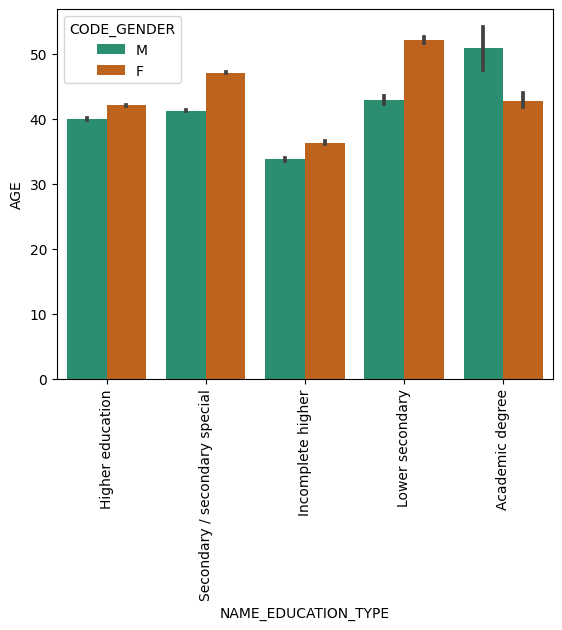

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Civil marriage'),
  Text(1, 0, 'Married'),
  Text(2, 0, 'Single / not married'),
  Text(3, 0, 'Separated'),
  Text(4, 0, 'Widow')])

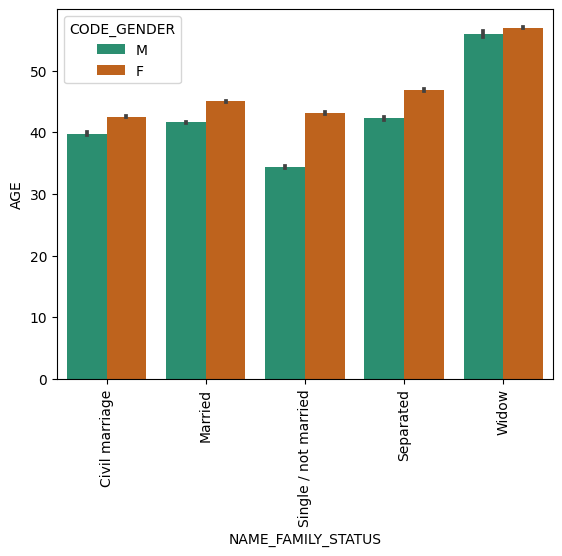

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Rented apartment'),
  Text(1, 0, 'House / apartment'),
  Text(2, 0, 'Municipal apartment'),
  Text(3, 0, 'With parents'),
  Text(4, 0, 'Co-op apartment'),
  Text(5, 0, 'Office apartment')])

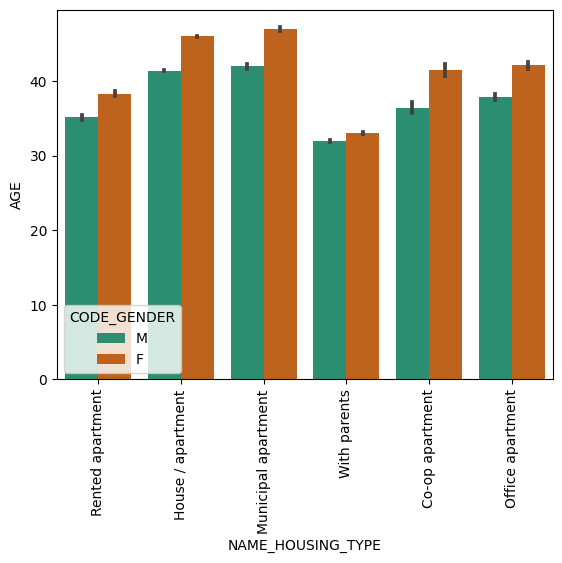

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Working'),
  Text(1, 0, 'Commercial associate'),
  Text(2, 0, 'Pensioner'),
  Text(3, 0, 'State servant'),
  Text(4, 0, 'Student')])

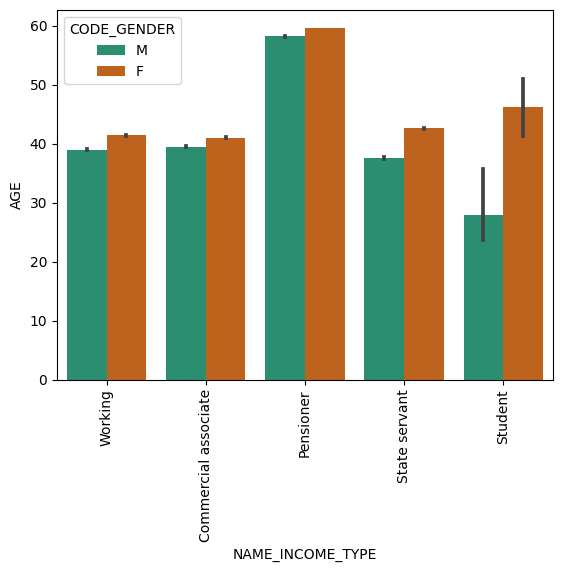

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 [Text(0, 0, 'Not Specified'),
  Text(1, 0, 'Security staff'),
  Text(2, 0, 'Sales staff'),
  Text(3, 0, 'Accountants'),
  Text(4, 0, 'Laborers'),
  Text(5, 0, 'Managers'),
  Text(6, 0, 'Drivers'),
  Text(7, 0, 'Core staff'),
  Text(8, 0, 'High skill tech staff'),
  Text(9, 0, 'Cleaning staff'),
  Text(10, 0, 'Private service staff'),
  Text(11, 0, 'Cooking staff'),
  Text(12, 0, 'Low-skill Laborers'),
  Text(13, 0, 'Medicine staff'),
  Text(14, 0, 'Secretaries'),
  Text(15, 0, 'Waiters/barmen staff'),
  Text(16, 0, 'HR staff'),
  Text(17, 0, 'Realty agents'),
  Text(18, 0, 'IT staff')])

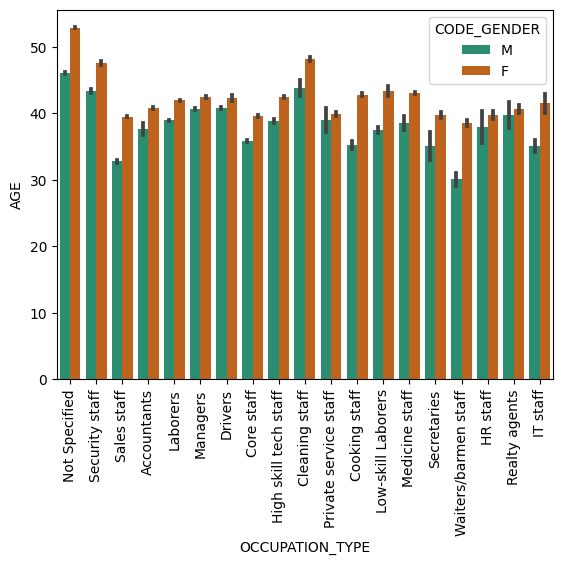

In [22]:
for col in object_col.drop(['FLAG_EMAIL', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'FLAG_PHONE', 'FLAG_WORK_PHONE'],axis=1).columns:
    if col != 'CODE_GENDER':
        palette = sns.color_palette('Dark2')
        ax = sns.barplot(data = application, 
                         x= col,
                         y='AGE',
                         hue = 'CODE_GENDER',
                         palette=palette)
        
        plt.xticks(rotation=90)

        plt.show()

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Higher education'),
  Text(1, 0, 'Secondary / secondary special'),
  Text(2, 0, 'Incomplete higher'),
  Text(3, 0, 'Lower secondary'),
  Text(4, 0, 'Academic degree')])

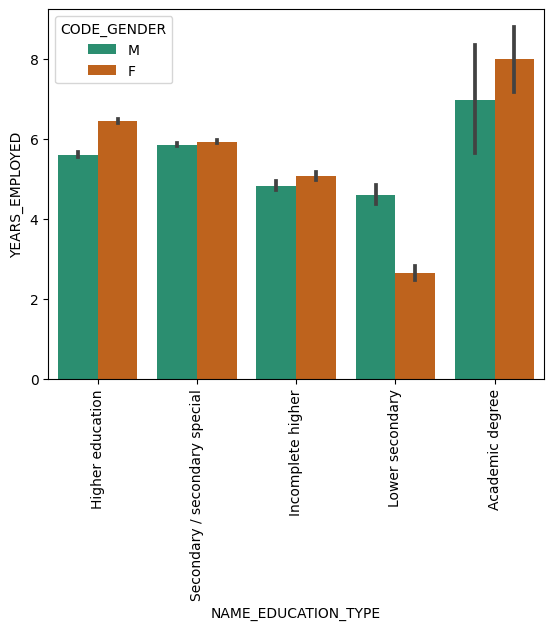

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Civil marriage'),
  Text(1, 0, 'Married'),
  Text(2, 0, 'Single / not married'),
  Text(3, 0, 'Separated'),
  Text(4, 0, 'Widow')])

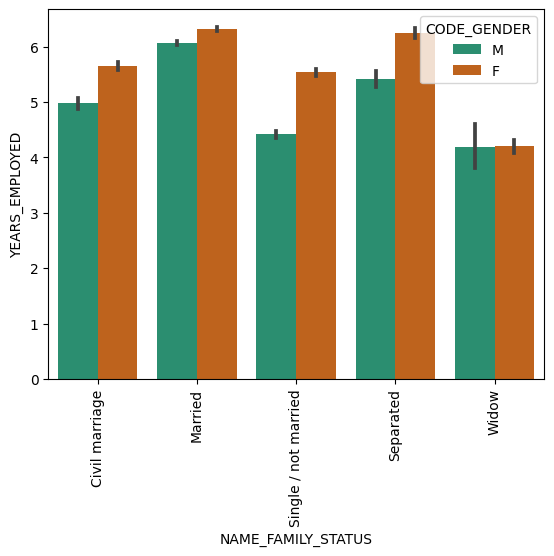

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Rented apartment'),
  Text(1, 0, 'House / apartment'),
  Text(2, 0, 'Municipal apartment'),
  Text(3, 0, 'With parents'),
  Text(4, 0, 'Co-op apartment'),
  Text(5, 0, 'Office apartment')])

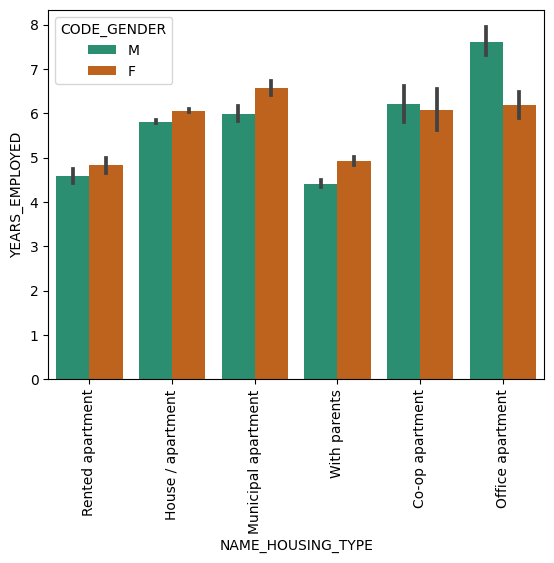

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Working'),
  Text(1, 0, 'Commercial associate'),
  Text(2, 0, 'Pensioner'),
  Text(3, 0, 'State servant'),
  Text(4, 0, 'Student')])

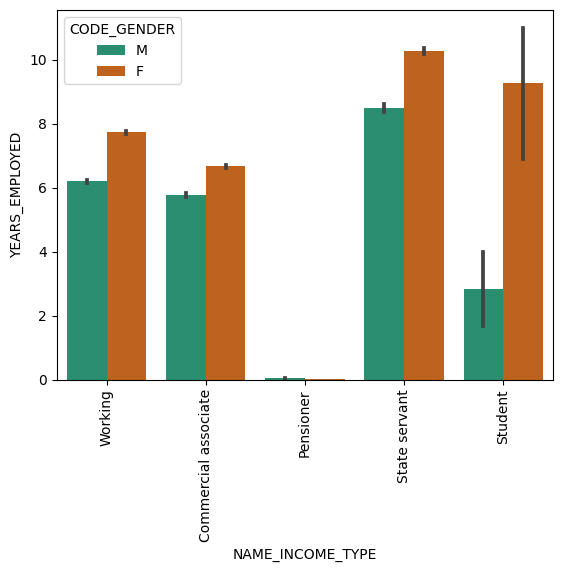

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 [Text(0, 0, 'Not Specified'),
  Text(1, 0, 'Security staff'),
  Text(2, 0, 'Sales staff'),
  Text(3, 0, 'Accountants'),
  Text(4, 0, 'Laborers'),
  Text(5, 0, 'Managers'),
  Text(6, 0, 'Drivers'),
  Text(7, 0, 'Core staff'),
  Text(8, 0, 'High skill tech staff'),
  Text(9, 0, 'Cleaning staff'),
  Text(10, 0, 'Private service staff'),
  Text(11, 0, 'Cooking staff'),
  Text(12, 0, 'Low-skill Laborers'),
  Text(13, 0, 'Medicine staff'),
  Text(14, 0, 'Secretaries'),
  Text(15, 0, 'Waiters/barmen staff'),
  Text(16, 0, 'HR staff'),
  Text(17, 0, 'Realty agents'),
  Text(18, 0, 'IT staff')])

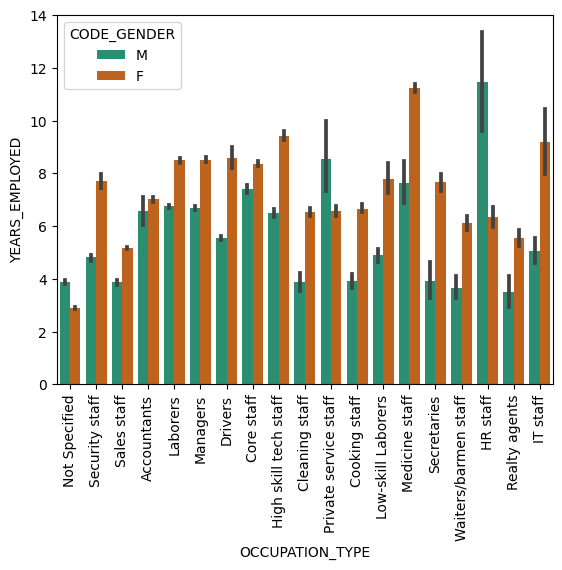

In [23]:
for col in object_col.drop(['FLAG_EMAIL', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'FLAG_PHONE', 'FLAG_WORK_PHONE'],axis=1).columns:
    if col != 'CODE_GENDER':
        palette = sns.color_palette('Dark2')
        ax = sns.barplot(data = application, 
                         x= col,
                         y='YEARS_EMPLOYED',
                         hue = 'CODE_GENDER',
                         palette=palette)
        
        plt.xticks(rotation=90)

        plt.show()

# Credit csv

In [24]:
credit.shape

(1048575, 3)

In [25]:
for col in credit.columns:
    print(f'colum name: {col}')
    print(credit[col].value_counts())
    print(30*'---')

colum name: ID
5016769    61
5002806    61
5118192    61
5145767    61
5078567    61
           ..
5028795     1
5148442     1
5053900     1
5046332     1
5079047     1
Name: ID, Length: 45985, dtype: int64
------------------------------------------------------------------------------------------
colum name: MONTHS_BALANCE
-1     34436
-2     34209
 0     33856
-3     33854
-4     33365
       ...  
-56     2109
-57     1649
-58     1255
-59      820
-60      415
Name: MONTHS_BALANCE, Length: 61, dtype: int64
------------------------------------------------------------------------------------------
colum name: STATUS
C    442031
0    383120
X    209230
1     11090
5      1693
2       868
3       320
4       223
Name: STATUS, dtype: int64
------------------------------------------------------------------------------------------


<AxesSubplot: >

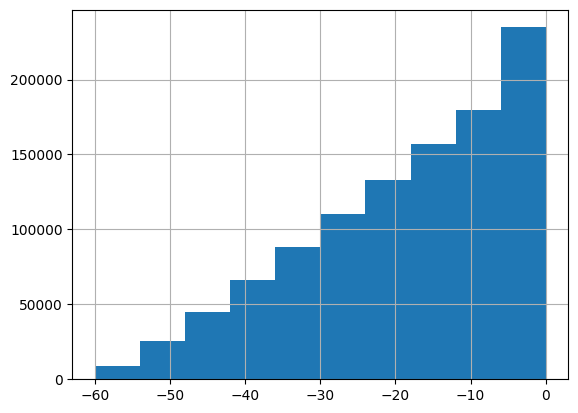

In [26]:
credit['MONTHS_BALANCE'].hist()

In [27]:
credit.isna().sum()

ID                0
MONTHS_BALANCE    0
STATUS            0
dtype: int64

In [28]:
print(f'The credit df have {credit["ID"].duplicated(keep="first").sum()} values with the same ID')

The credit df have 1002590 values with the same ID


<Figure size 500x500 with 0 Axes>

Text(0.0, 442031.0, '442031')

Text(1.0, 383120.0, '383120')

Text(2.0, 209230.0, '209230')

Text(3.0, 11090.0, '11090')

Text(4.0, 1693.0, '1693')

Text(5.0, 868.0, '868')

Text(6.0, 320.0, '320')

Text(7.0, 223.0, '223')

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'C'),
  Text(1, 0, '0'),
  Text(2, 0, 'X'),
  Text(3, 0, '1'),
  Text(4, 0, '5'),
  Text(5, 0, '2'),
  Text(6, 0, '3'),
  Text(7, 0, '4')])

Text(0.5, 1.0, 'STATUS')

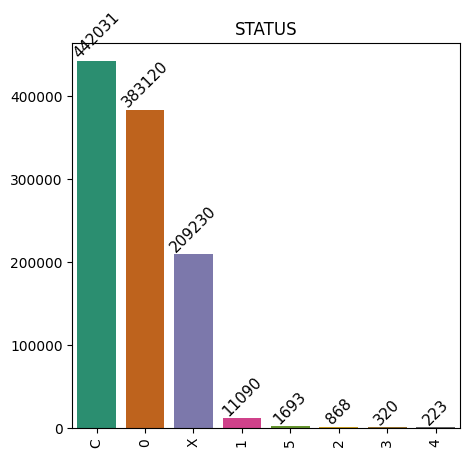

In [29]:
plt.figure(figsize=(5, 5))
ax = sns.barplot(x=credit['STATUS'].value_counts().index,
            y=credit['STATUS'].value_counts().values,
            palette=palette)
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height(), '%d' % int(p.get_height()),
            fontsize=11, color='black', ha='center', va='bottom',rotation=45)
plt.xticks(rotation=90)
plt.title(col)

plt.show()

In [30]:
# Label encoding: I assign a 0 value for each status values which indicate normal or null debt payement
# and I assign 1 point for each status values which indicate a retard in debt payemnt 
status_map = {'X':0,
              'C':0,
              '0':0,
              '1':1,
              '2':2,
              '3':3,
              '4':4,
              '5':5}
# I change 'STATUS' name in 'POINTS' name 
credit['POINTS'] = credit['STATUS'].map(status_map)

In [31]:
# Group the 'credit' dataframe by 'ID'
# For each 'ID', count the number of 'MONTHS_BALANCE' and sum the 'POINTS' 
credit_id = credit.groupby('ID').agg({'MONTHS_BALANCE':'count', 'POINTS':'sum'})

,MONTHS_BALANCE,POINTS
ID,,
5001711,4,0
5001712,19,0
5001713,22,0
5001714,15,0
5001715,60,0


,MONTHS_BALANCE,POINTS
count,45985.000000,45985.000000
mean,22.802544,0.503273
std,15.492771,4.863690
min,1.000000,0.000000
25%,10.000000,0.000000
50%,19.000000,0.000000
75%,34.000000,0.000000
max,61.000000,240.000000


array([[<AxesSubplot: title={'center': 'MONTHS_BALANCE'}>,
        <AxesSubplot: title={'center': 'POINTS'}>]], dtype=object)

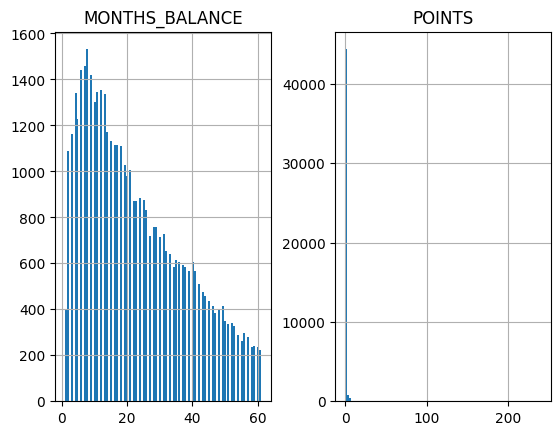

In [32]:
# EDA
credit_id.head()
credit_id.describe()
credit_id.hist(bins=100)


In [33]:
# Check all points
credit_id['POINTS'].value_counts()

0      40635
1       2702
2       1045
3        489
4        284
       ...  
90         1
54         1
160        1
44         1
17         1
Name: POINTS, Length: 80, dtype: int64

In [34]:
np.percentile(credit_id['POINTS'],95)

2.0

In [35]:
# Initialize a new column 'CREDIT_RATING' in the 'credit_id' dataframe and set its value to None
credit_id['CREDIT_RATING']= None

# Apply a function to each row in the 'credit_id' dataframe to calculate the 'CREDIT_RATING'
# If 'MONTHS_BALANCE' is less than the 50th percentile of all 'MONTHS_BALANCE' and 'POINTS' 
# is less than 95th percentile, set 'CREDIT_RATING' to 1
# If 'POINTS' is equal to 0, also set 'CREDIT_RATING' to 1
# Otherwise, set 'CREDIT_RATING' to 0
credit_id['CREDIT_RATING'] = credit_id.apply(lambda row: 1 if row['MONTHS_BALANCE'] 
                                             < np.percentile(credit_id['MONTHS_BALANCE'],50) and 
                                             row['POINTS'] 
                                             < np.percentile(credit_id['MONTHS_BALANCE'],95)
                                             else (1 if row['POINTS'] == 0 else 0), axis=1)


In [36]:
application.shape
credit_id.shape

(427285, 18)

(45985, 3)

In [37]:
# There are many more ids in 'application' df
#so I merge them keeping only the ID value which is in common between the two dataframes 
merge_df = pd.merge(application, credit_id, on='ID', how='inner')

# and I drop useless values
merge_df = merge_df.drop(['ID','POINTS','MONTHS_BALANCE'],axis=1)

In [38]:
merge_df.shape
merge_df['CREDIT_RATING'].value_counts()
merge_df.isna().sum()

(35493, 18)

1    33035
0     2458
Name: CREDIT_RATING, dtype: int64

CODE_GENDER            0
FLAG_OWN_CAR           0
FLAG_OWN_REALTY        0
CNT_CHILDREN           0
AMT_INCOME_TOTAL       0
NAME_INCOME_TYPE       0
NAME_EDUCATION_TYPE    0
NAME_FAMILY_STATUS     0
NAME_HOUSING_TYPE      0
FLAG_MOBIL             0
FLAG_WORK_PHONE        0
FLAG_PHONE             0
FLAG_EMAIL             0
OCCUPATION_TYPE        0
CNT_FAM_MEMBERS        0
AGE                    0
YEARS_EMPLOYED         0
CREDIT_RATING          0
dtype: int64

# Distribuition plot for credit relase

<Figure size 1500x400 with 0 Axes>

<AxesSubplot: xlabel='CODE_GENDER', ylabel='Count'>

([0, 1], [Text(0, 0, 'M'), Text(1, 0, 'F')])

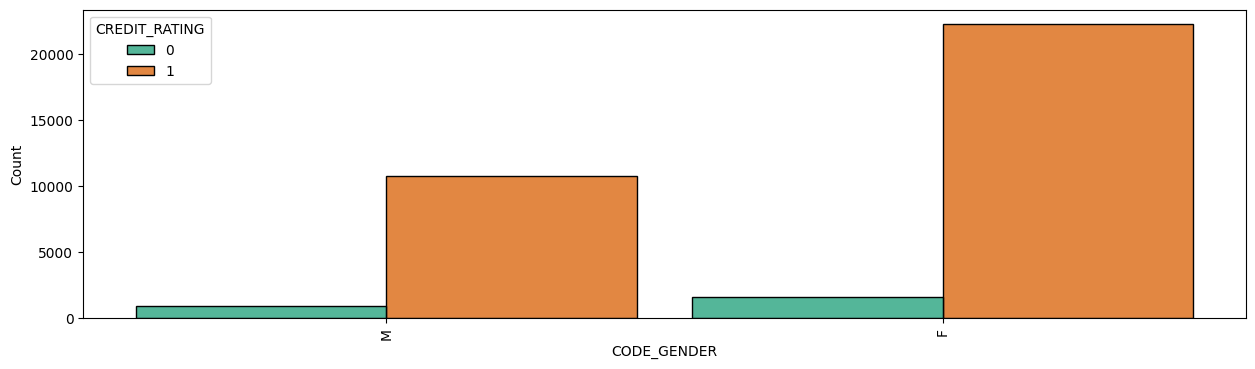

<Figure size 1500x400 with 0 Axes>

<AxesSubplot: xlabel='FLAG_OWN_CAR', ylabel='Count'>

([0, 1], [Text(0, 0, 'Y'), Text(1, 0, 'N')])

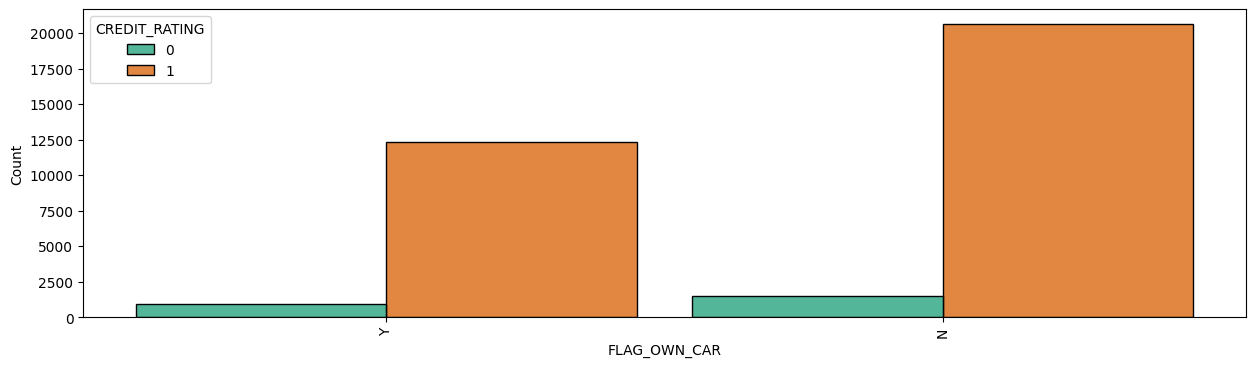

<Figure size 1500x400 with 0 Axes>

<AxesSubplot: xlabel='FLAG_OWN_REALTY', ylabel='Count'>

([0, 1], [Text(0, 0, 'Y'), Text(1, 0, 'N')])

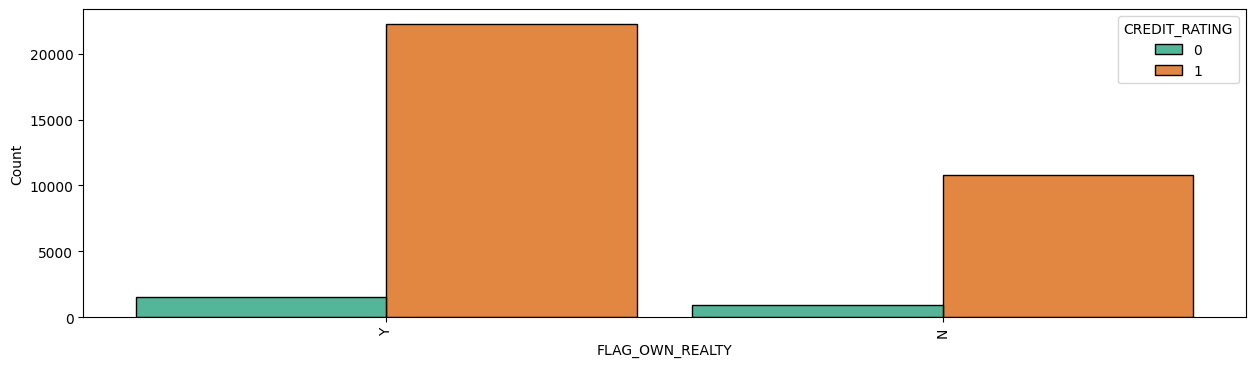

<Figure size 1500x400 with 0 Axes>

<AxesSubplot: xlabel='NAME_INCOME_TYPE', ylabel='Count'>

([0, 1, 2, 3, 4],
 [Text(0, 0, 'Working'),
  Text(1, 0, 'Commercial associate'),
  Text(2, 0, 'Pensioner'),
  Text(3, 0, 'State servant'),
  Text(4, 0, 'Student')])

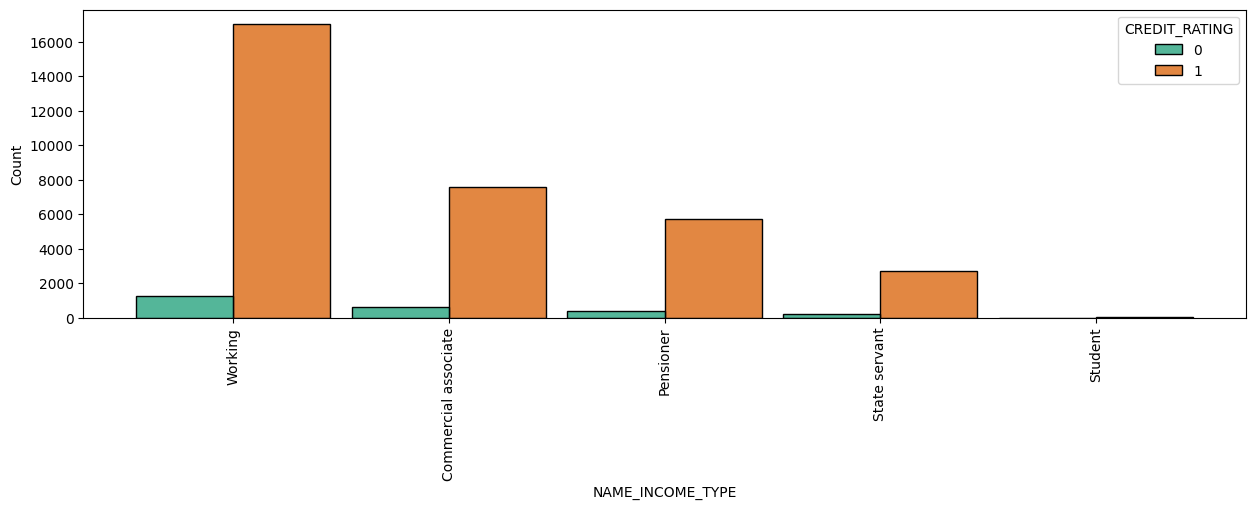

<Figure size 1500x400 with 0 Axes>

<AxesSubplot: xlabel='NAME_EDUCATION_TYPE', ylabel='Count'>

([0, 1, 2, 3, 4],
 [Text(0, 0, 'Higher education'),
  Text(1, 0, 'Secondary / secondary special'),
  Text(2, 0, 'Incomplete higher'),
  Text(3, 0, 'Lower secondary'),
  Text(4, 0, 'Academic degree')])

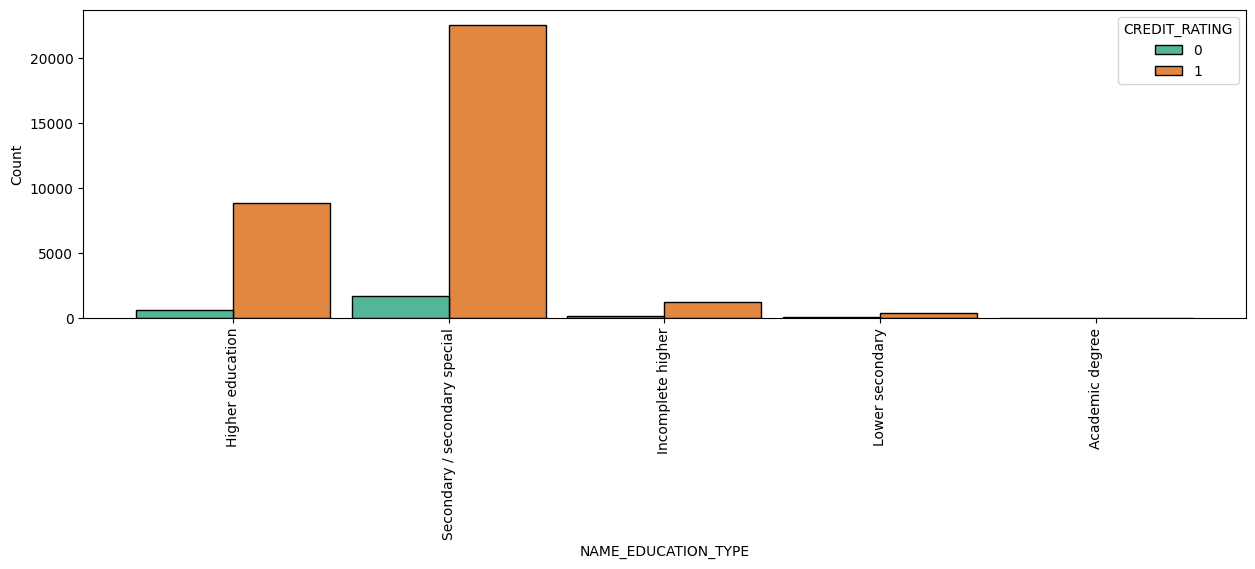

<Figure size 1500x400 with 0 Axes>

<AxesSubplot: xlabel='NAME_FAMILY_STATUS', ylabel='Count'>

([0, 1, 2, 3, 4],
 [Text(0, 0, 'Civil marriage'),
  Text(1, 0, 'Married'),
  Text(2, 0, 'Single / not married'),
  Text(3, 0, 'Separated'),
  Text(4, 0, 'Widow')])

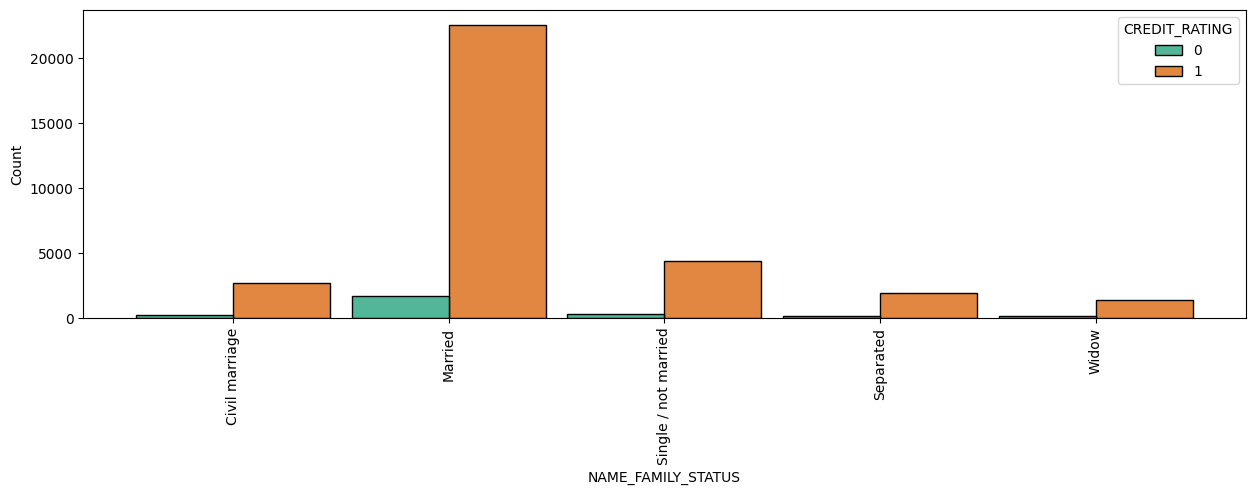

<Figure size 1500x400 with 0 Axes>

<AxesSubplot: xlabel='NAME_HOUSING_TYPE', ylabel='Count'>

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Rented apartment'),
  Text(1, 0, 'House / apartment'),
  Text(2, 0, 'Municipal apartment'),
  Text(3, 0, 'With parents'),
  Text(4, 0, 'Co-op apartment'),
  Text(5, 0, 'Office apartment')])

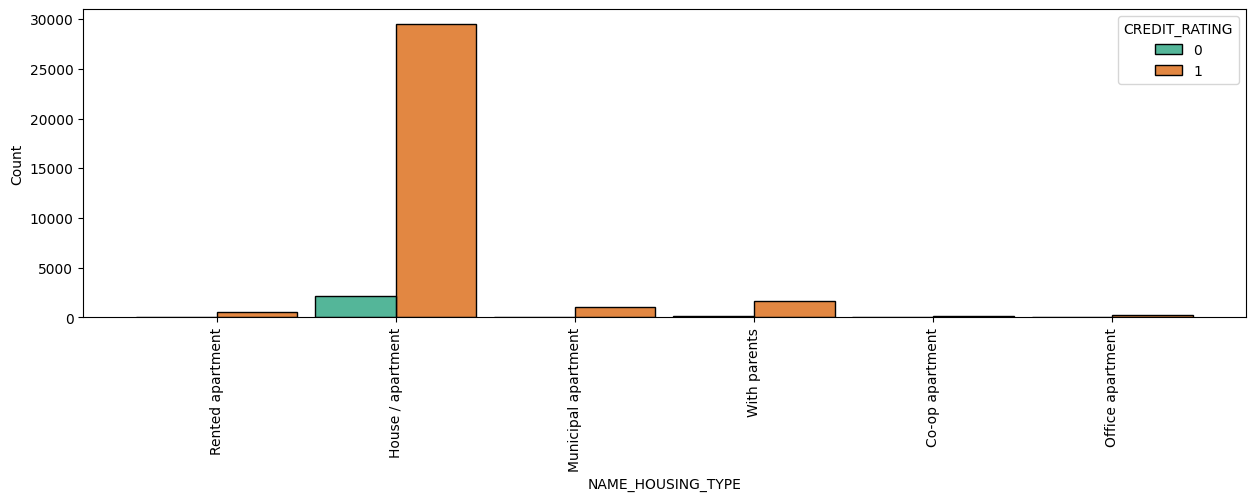

<Figure size 1500x400 with 0 Axes>

<AxesSubplot: xlabel='OCCUPATION_TYPE', ylabel='Count'>

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 [Text(0, 0, 'Not Specified'),
  Text(1, 0, 'Security staff'),
  Text(2, 0, 'Sales staff'),
  Text(3, 0, 'Accountants'),
  Text(4, 0, 'Laborers'),
  Text(5, 0, 'Managers'),
  Text(6, 0, 'Drivers'),
  Text(7, 0, 'Core staff'),
  Text(8, 0, 'High skill tech staff'),
  Text(9, 0, 'Cleaning staff'),
  Text(10, 0, 'Private service staff'),
  Text(11, 0, 'Cooking staff'),
  Text(12, 0, 'Low-skill Laborers'),
  Text(13, 0, 'Medicine staff'),
  Text(14, 0, 'Secretaries'),
  Text(15, 0, 'Waiters/barmen staff'),
  Text(16, 0, 'HR staff'),
  Text(17, 0, 'Realty agents'),
  Text(18, 0, 'IT staff')])

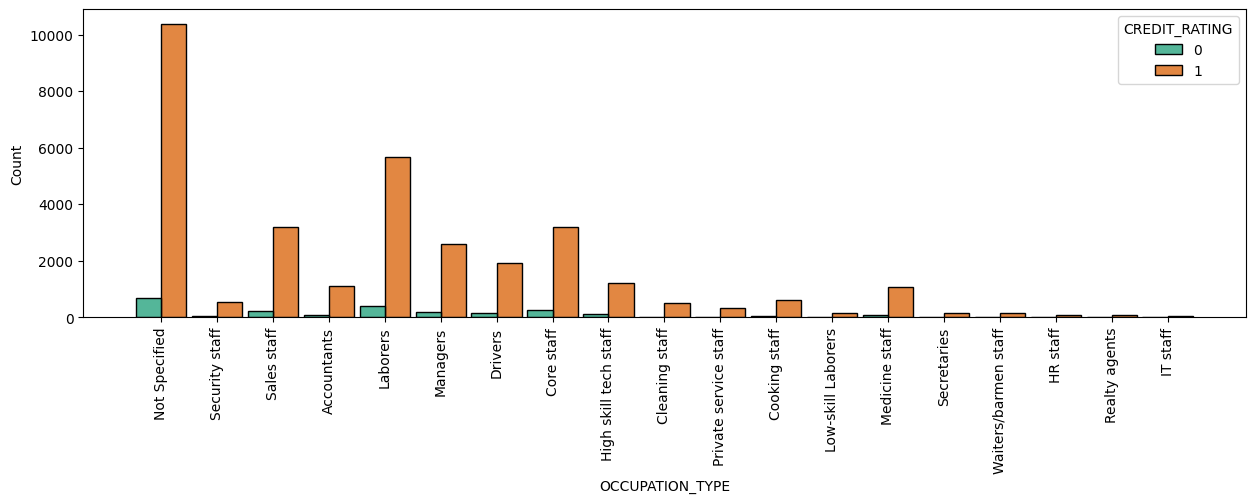

In [39]:
# I plot 'CREDIT_RATING' for each categorical variables 
for column in merge_df.columns:
  if merge_df[column].dtype == 'object':
    if column != 'CREDIT_RATING':
      palette = sns.color_palette('Dark2')
      plt.figure(figsize=(15, 4))

      sns.histplot(data= merge_df, x=column, 
                   hue='CREDIT_RATING',
                   multiple='dodge',
                   palette=palette,
                   shrink=.9)
      plt.xticks(rotation=90)

      plt.show()

<Figure size 1500x400 with 0 Axes>

<AxesSubplot: xlabel='CNT_CHILDREN', ylabel='Count'>

(array([-0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,
         2.  ,  2.25]),
 [Text(-0.25, 0, '−0.25'),
  Text(0.0, 0, '0.00'),
  Text(0.25, 0, '0.25'),
  Text(0.5, 0, '0.50'),
  Text(0.75, 0, '0.75'),
  Text(1.0, 0, '1.00'),
  Text(1.25, 0, '1.25'),
  Text(1.5, 0, '1.50'),
  Text(1.75, 0, '1.75'),
  Text(2.0, 0, '2.00'),
  Text(2.25, 0, '2.25')])

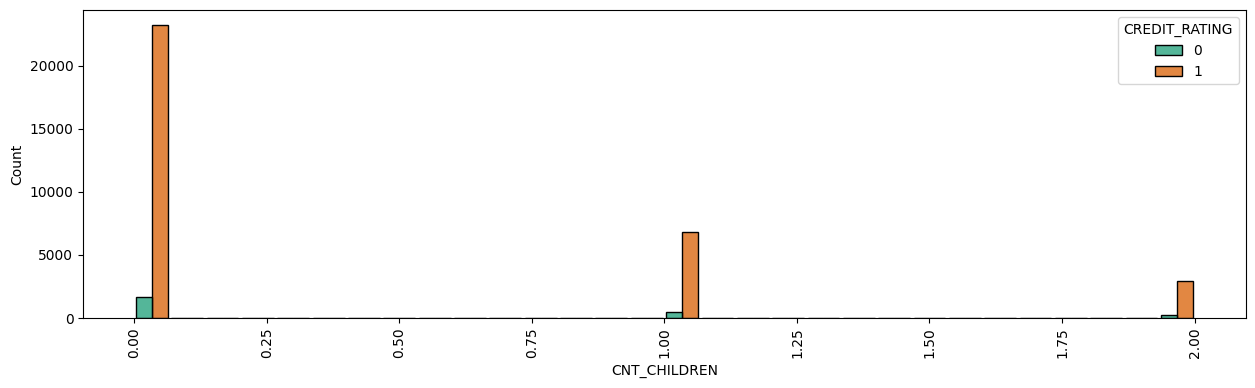

<Figure size 1500x400 with 0 Axes>

<AxesSubplot: xlabel='AMT_INCOME_TOTAL', ylabel='Count'>

(array([     0., 100000., 200000., 300000., 400000., 500000., 600000.]),
 [Text(0.0, 0, '0'),
  Text(100000.0, 0, '100000'),
  Text(200000.0, 0, '200000'),
  Text(300000.0, 0, '300000'),
  Text(400000.0, 0, '400000'),
  Text(500000.0, 0, '500000'),
  Text(600000.0, 0, '600000')])

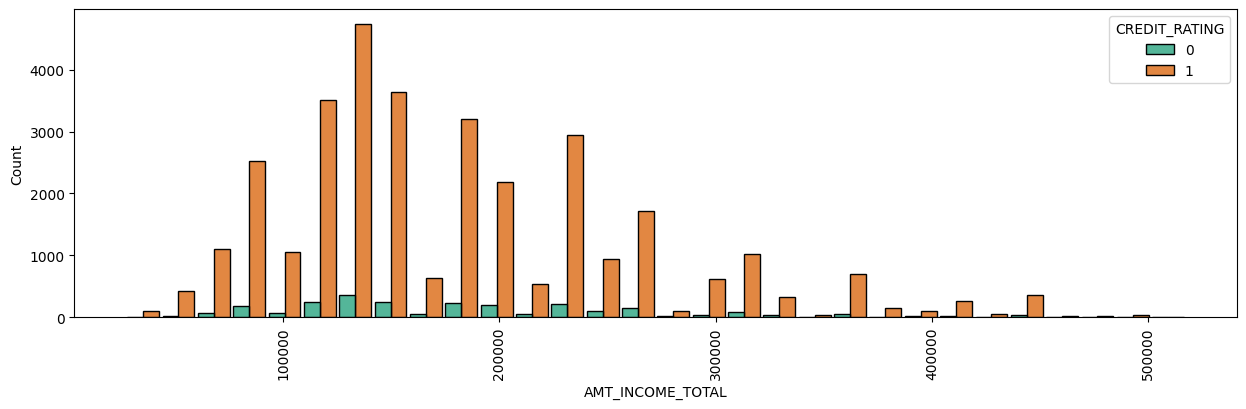

<Figure size 1500x400 with 0 Axes>

<AxesSubplot: xlabel='CNT_FAM_MEMBERS', ylabel='Count'>

(array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5]),
 [Text(0.5, 0, '0.5'),
  Text(1.0, 0, '1.0'),
  Text(1.5, 0, '1.5'),
  Text(2.0, 0, '2.0'),
  Text(2.5, 0, '2.5'),
  Text(3.0, 0, '3.0'),
  Text(3.5, 0, '3.5'),
  Text(4.0, 0, '4.0'),
  Text(4.5, 0, '4.5')])

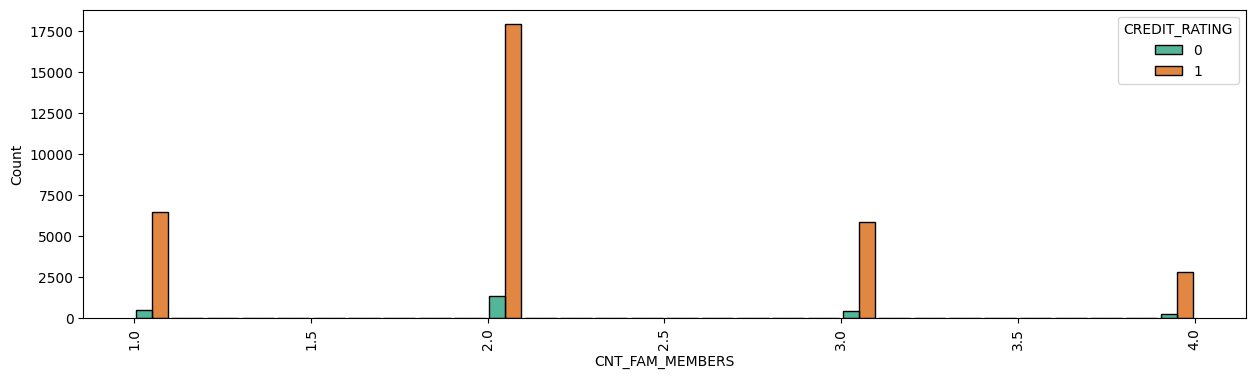

<Figure size 1500x400 with 0 Axes>

<AxesSubplot: xlabel='AGE', ylabel='Count'>

(array([10., 20., 30., 40., 50., 60., 70., 80.]),
 [Text(10.0, 0, '10'),
  Text(20.0, 0, '20'),
  Text(30.0, 0, '30'),
  Text(40.0, 0, '40'),
  Text(50.0, 0, '50'),
  Text(60.0, 0, '60'),
  Text(70.0, 0, '70'),
  Text(80.0, 0, '80')])

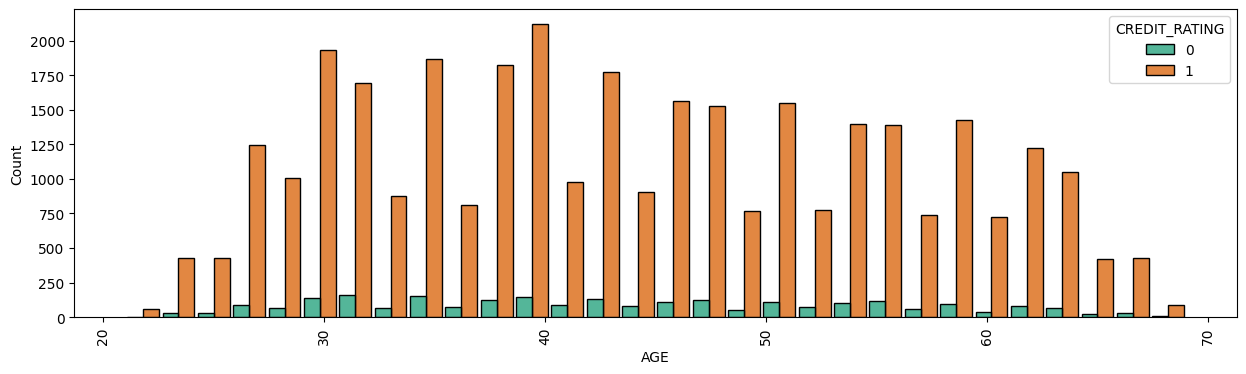

<Figure size 1500x400 with 0 Axes>

<AxesSubplot: xlabel='YEARS_EMPLOYED', ylabel='Count'>

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.]),
 [Text(-10.0, 0, '−10'),
  Text(0.0, 0, '0'),
  Text(10.0, 0, '10'),
  Text(20.0, 0, '20'),
  Text(30.0, 0, '30'),
  Text(40.0, 0, '40'),
  Text(50.0, 0, '50')])

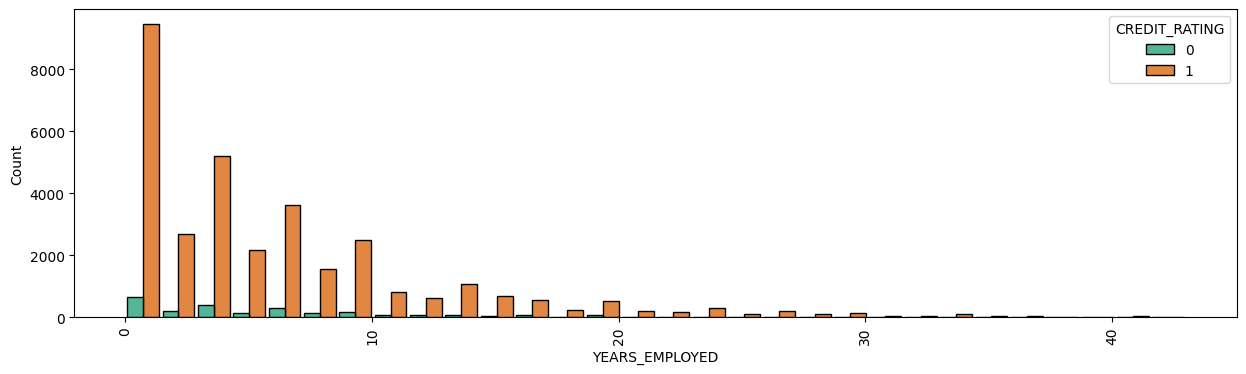

In [40]:
# I plot 'CREDIT_RATING' for each numerical variables 
for column in numerical_cols.drop(['ID'], axis=1):
    if column != 'CREDIT_RATING':
      palette = sns.color_palette('Dark2')
      plt.figure(figsize=(15, 4))

      sns.histplot(data= merge_df, x=column, hue='CREDIT_RATING', bins= 30, multiple='dodge', palette=palette, shrink=.9)
      plt.xticks(rotation=90)

      plt.show()

# Label encoded

In [41]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

enc_df = merge_df.copy()
for col in enc_df.columns:
    if enc_df[col].dtype=='object':
        enc_df[col]=le.fit_transform(enc_df[col])
enc_df.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,AGE,YEARS_EMPLOYED,CREDIT_RATING
0,1,1,1,0,427500.0,4,1,0,4,1,1,0,0,12,2.0,33.0,12.0,1
1,1,1,1,0,427500.0,4,1,0,4,1,1,0,0,12,2.0,33.0,12.0,1
2,1,1,1,0,112500.0,4,4,1,1,1,0,0,0,17,2.0,59.0,3.0,1
3,0,0,1,0,270000.0,0,4,3,1,1,0,1,1,15,1.0,52.0,8.0,1
4,0,0,1,0,270000.0,0,4,3,1,1,0,1,1,15,1.0,52.0,8.0,1


<AxesSubplot: >

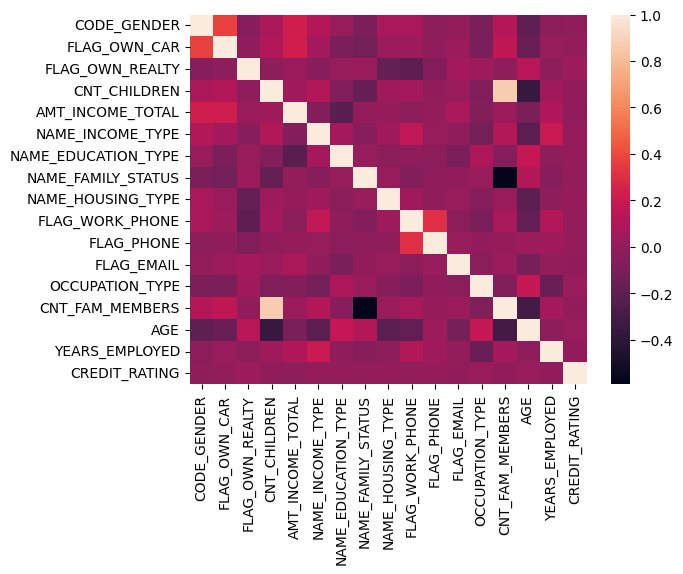

In [42]:
sns.heatmap(enc_df.drop(['FLAG_MOBIL'],axis=1).corr())

# Models

In [43]:
x = enc_df.iloc[:,:-1]
y = enc_df.iloc[:,-1]

In [44]:
RANDOM_SEED = 97
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import CategoricalNB

In [45]:
# function to plot with sns the confusion matrix
def plot_cm(y_true, y_pred):
    df_cm = pd.DataFrame(confusion_matrix(y_test,y_pred),
    columns=['Predicted Positive', 'Predicted Negative'],
    index= ['Actual Positive', 'Actual Negative'])
    sns.heatmap(df_cm, annot=True,fmt='d', cmap='Blues')

In [46]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=.2, 
                                                    random_state=RANDOM_SEED)
mms = MinMaxScaler()
mms.fit_transform(x_train)
mms.transform(x_test) 

array([[0.        , 1.        , 0.        , ..., 0.33333333, 0.33333333,
        0.27906977],
       [1.        , 0.        , 0.        , ..., 0.33333333, 0.125     ,
        0.18604651],
       [0.        , 0.        , 1.        , ..., 0.33333333, 0.75      ,
        0.        ],
       ...,
       [0.        , 1.        , 0.        , ..., 0.        , 0.375     ,
        0.09302326],
       [0.        , 0.        , 0.        , ..., 0.        , 0.79166667,
        0.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 0.54166667,
        0.04651163]])

array([[0.        , 0.        , 1.        , ..., 0.33333333, 0.41666667,
        0.13953488],
       [0.        , 0.        , 0.        , ..., 0.33333333, 0.6875    ,
        0.62790698],
       [1.        , 1.        , 0.        , ..., 0.        , 0.10416667,
        0.02325581],
       ...,
       [1.        , 1.        , 0.        , ..., 1.        , 0.39583333,
        0.13953488],
       [1.        , 1.        , 1.        , ..., 0.33333333, 0.25      ,
        0.1627907 ],
       [0.        , 0.        , 1.        , ..., 0.33333333, 0.75      ,
        0.        ]])

In [47]:
y_train.value_counts()
y_test.value_counts()
# The credit value 0 in undersampled

1    26401
0     1993
Name: CREDIT_RATING, dtype: int64

1    6634
0     465
Name: CREDIT_RATING, dtype: int64

In [48]:
from imblearn.over_sampling import SMOTE
oversampler = SMOTE()
x_train,y_train = oversampler.fit_resample(x_train,y_train)
x_test,y_test=oversampler.fit_resample(x_test,y_test)

In [49]:
y_train.value_counts()
y_test.value_counts()

1    26401
0    26401
Name: CREDIT_RATING, dtype: int64

1    6634
0    6634
Name: CREDIT_RATING, dtype: int64

### Logistic Regression

LogisticRegression()

              precision    recall  f1-score   support

           0       0.53      0.48      0.50      6634
           1       0.53      0.58      0.55      6634

    accuracy                           0.53     13268
   macro avg       0.53      0.53      0.53     13268
weighted avg       0.53      0.53      0.53     13268



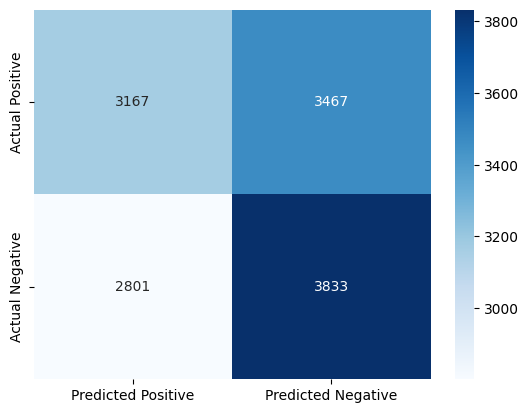

In [50]:
lr=LogisticRegression()
lr.fit(x_train,y_train)

print(classification_report(y_true=y_test, y_pred=lr.predict(x_test)))
plot_cm(y_test,lr.predict(x_test))

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': (1, 10, 100),
                         'solver': ('lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'sag', 'saga')})

LogisticRegression(C=10, solver='newton-cg')

The best paramters are: {'C': 10, 'solver': 'newton-cg'}
              precision    recall  f1-score   support

           0       0.69      0.78      0.73      6634
           1       0.75      0.66      0.70      6634

    accuracy                           0.72     13268
   macro avg       0.72      0.72      0.72     13268
weighted avg       0.72      0.72      0.72     13268



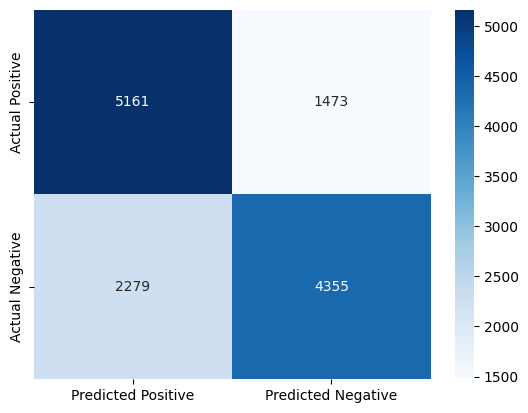

In [51]:
# I use a grid search to discover the best model params 
lr=LogisticRegression()
params = {'solver':('lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'),
         'C':(1,10,100)}
grid = GridSearchCV(lr,params)
grid.fit(x_train,y_train)
lr = grid.best_estimator_
lr.fit(x_train,y_train)

print(f'The best paramters are: {grid.best_params_}')
print(classification_report(y_true=y_test, y_pred=lr.predict(x_test)))
plot_cm(y_test,lr.predict(x_test))

With Logistic regressionv the accuracy is 0.72, however the false positive are to much (precision on bad credit score is 0.69)
I train another classification model 

Feature: CODE_GENDER, Score: -1.02
Feature: FLAG_OWN_CAR, Score: -0.17
Feature: FLAG_OWN_REALTY, Score: -0.11
Feature: CNT_CHILDREN, Score: -0.0
Feature: AMT_INCOME_TOTAL, Score: 0.01
Feature: NAME_INCOME_TYPE, Score: 0.01
Feature: NAME_EDUCATION_TYPE, Score: 0.03
Feature: NAME_FAMILY_STATUS, Score: 0.04
Feature: NAME_HOUSING_TYPE, Score: 0.05
Feature: FLAG_MOBIL, Score: 0.2
Feature: FLAG_WORK_PHONE, Score: 0.37
Feature: FLAG_PHONE, Score: 0.68
Feature: FLAG_EMAIL, Score: 0.71
Feature: OCCUPATION_TYPE, Score: 0.72
Feature: CNT_FAM_MEMBERS, Score: 0.78
Feature: AGE, Score: 0.97
Feature: YEARS_EMPLOYED, Score: 1.31


<AxesSubplot: >

(array([-1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5]),
 [Text(-1.5, 0, '−1.5'),
  Text(-1.0, 0, '−1.0'),
  Text(-0.5, 0, '−0.5'),
  Text(0.0, 0, '0.0'),
  Text(0.5, 0, '0.5'),
  Text(1.0, 0, '1.0'),
  Text(1.5, 0, '1.5')])

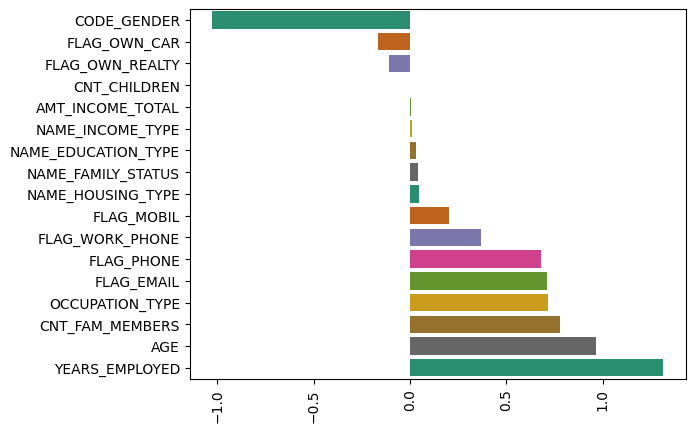

In [53]:
# one of the goals of the task is to make it clear to the customer 
#why he or she was or was not issued a credit card
# so I’ve developed a code that explains to our customers which variables are the most crucial.
importance = lr.coef_[0]
importance.sort()

for i, values in enumerate(importance):
    print(f'Feature: {enc_df.columns[i]}, Score: {round(values,2)}')
    
sns.barplot(y=enc_df.columns[:-1],
             x=importance,
           palette=palette)
plt.xticks(rotation=90)

### Naive Bayes

CategoricalNB()

              precision    recall  f1-score   support

           0       0.78      0.80      0.79      6634
           1       0.79      0.78      0.78      6634

    accuracy                           0.79     13268
   macro avg       0.79      0.79      0.79     13268
weighted avg       0.79      0.79      0.79     13268



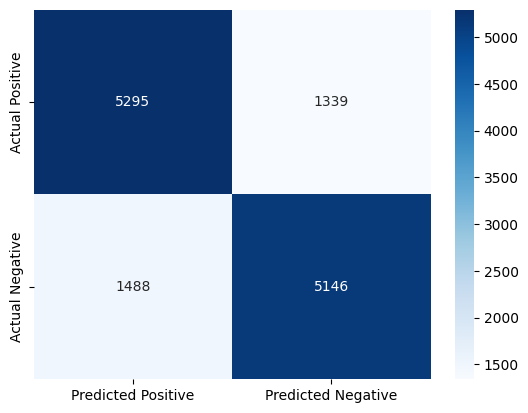

In [54]:
cnb = CategoricalNB()
cnb.fit(x_train,y_train)

print(classification_report(y_true=y_test, y_pred=cnb.predict(x_test)))
plot_cm(y_test, cnb.predict(x_test))

The naive bayes model had a better result than the logistic regression, however, I do not think it can be the best model because due to intrisic characteristic of the model you do not have a higher importance of the features and therefore I could not give a reason to the customer 

### Decision Tree

DecisionTreeClassifier(random_state=97)

              precision    recall  f1-score   support

           0       0.90      0.75      0.82      6634
           1       0.79      0.92      0.85      6634

    accuracy                           0.84     13268
   macro avg       0.84      0.84      0.83     13268
weighted avg       0.84      0.84      0.83     13268



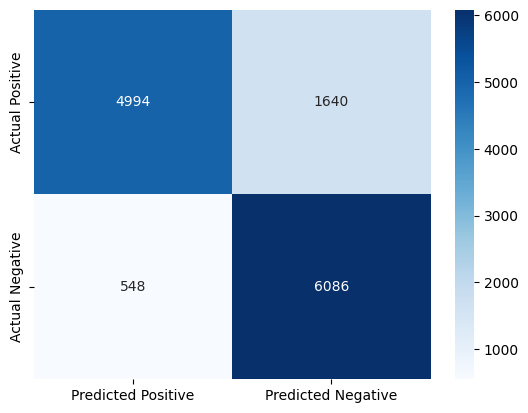

In [55]:
tree_clf = DecisionTreeClassifier(random_state=RANDOM_SEED)
tree_clf.fit(x_train,y_train)

print(classification_report(y_true=y_test, y_pred=tree_clf.predict(x_test)))
plot_cm(y_test, tree_clf.predict(x_test))

Feature: CODE_GENDER, Score: 0.0
Feature: FLAG_OWN_CAR, Score: 0.01
Feature: FLAG_OWN_REALTY, Score: 0.02
Feature: CNT_CHILDREN, Score: 0.02
Feature: AMT_INCOME_TOTAL, Score: 0.02
Feature: NAME_INCOME_TYPE, Score: 0.03
Feature: NAME_EDUCATION_TYPE, Score: 0.03
Feature: NAME_FAMILY_STATUS, Score: 0.03
Feature: NAME_HOUSING_TYPE, Score: 0.03
Feature: FLAG_MOBIL, Score: 0.04
Feature: FLAG_WORK_PHONE, Score: 0.05
Feature: FLAG_PHONE, Score: 0.05
Feature: FLAG_EMAIL, Score: 0.08
Feature: OCCUPATION_TYPE, Score: 0.11
Feature: CNT_FAM_MEMBERS, Score: 0.14
Feature: AGE, Score: 0.17
Feature: YEARS_EMPLOYED, Score: 0.19


<AxesSubplot: >

(array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ]),
 [Text(0.0, 0, '0.000'),
  Text(0.025, 0, '0.025'),
  Text(0.05, 0, '0.050'),
  Text(0.07500000000000001, 0, '0.075'),
  Text(0.1, 0, '0.100'),
  Text(0.125, 0, '0.125'),
  Text(0.15000000000000002, 0, '0.150'),
  Text(0.17500000000000002, 0, '0.175'),
  Text(0.2, 0, '0.200')])

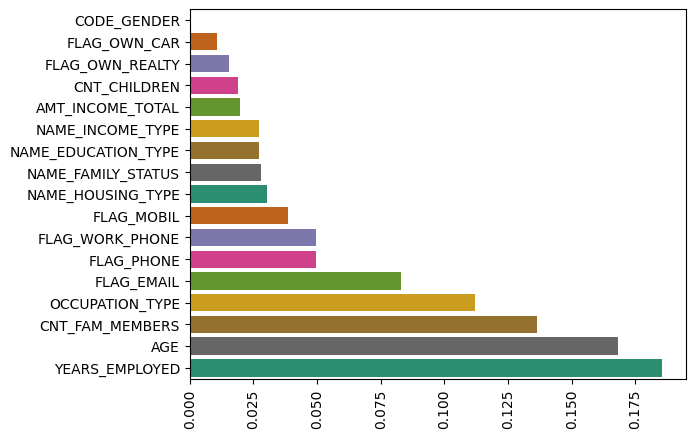

In [57]:
importance = tree_clf.feature_importances_
importance.sort()

for i,values in enumerate(importance):
    print(f'Feature: {enc_df.columns[i]}, Score: {round(values,2)}')
    
sns.barplot(y=enc_df.columns[:-1],
             x=importance,
           palette=palette)
plt.xticks(rotation=90)

### Random Forest

RandomForestClassifier(random_state=97)

              precision    recall  f1-score   support

           0       0.93      0.79      0.86      6634
           1       0.82      0.94      0.88      6634

    accuracy                           0.87     13268
   macro avg       0.87      0.87      0.87     13268
weighted avg       0.87      0.87      0.87     13268



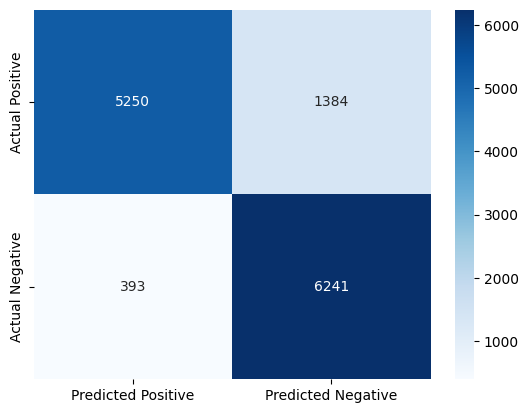

In [58]:
random_f = RandomForestClassifier(random_state=RANDOM_SEED)
random_f.fit(x_train,y_train)

print(classification_report(y_true=y_test, y_pred=random_f.predict(x_test)))
plot_cm(y_test, random_f.predict(x_test))

Feature: CODE_GENDER, Score: 0.0
Feature: FLAG_OWN_CAR, Score: 0.01
Feature: FLAG_OWN_REALTY, Score: 0.02
Feature: CNT_CHILDREN, Score: 0.02
Feature: AMT_INCOME_TOTAL, Score: 0.03
Feature: NAME_INCOME_TYPE, Score: 0.03
Feature: NAME_EDUCATION_TYPE, Score: 0.03
Feature: NAME_FAMILY_STATUS, Score: 0.03
Feature: NAME_HOUSING_TYPE, Score: 0.04
Feature: FLAG_MOBIL, Score: 0.05
Feature: FLAG_WORK_PHONE, Score: 0.05
Feature: FLAG_PHONE, Score: 0.05
Feature: FLAG_EMAIL, Score: 0.09
Feature: OCCUPATION_TYPE, Score: 0.12
Feature: CNT_FAM_MEMBERS, Score: 0.13
Feature: AGE, Score: 0.14
Feature: YEARS_EMPLOYED, Score: 0.16


<AxesSubplot: >

(array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18]),
 [Text(0.0, 0, '0.00'),
  Text(0.02, 0, '0.02'),
  Text(0.04, 0, '0.04'),
  Text(0.06, 0, '0.06'),
  Text(0.08, 0, '0.08'),
  Text(0.1, 0, '0.10'),
  Text(0.12, 0, '0.12'),
  Text(0.14, 0, '0.14'),
  Text(0.16, 0, '0.16'),
  Text(0.18, 0, '0.18')])

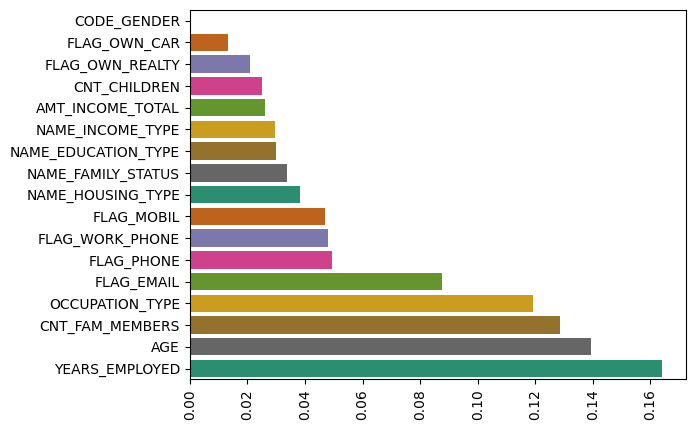

In [59]:
importance = random_f.feature_importances_
importance.sort()

i=0
for values in importance:
    print(f'Feature: {enc_df.columns[i]}, Score: {round(values,2)}')
    i+=1
    
sns.barplot(y=enc_df.columns[:-1],
             x=importance,
           palette=palette)
plt.xticks(rotation=90)

### Support Vector Machine

SVC(C=0.8, random_state=97)

              precision    recall  f1-score   support

           0       0.52      0.52      0.52      6634
           1       0.52      0.52      0.52      6634

    accuracy                           0.52     13268
   macro avg       0.52      0.52      0.52     13268
weighted avg       0.52      0.52      0.52     13268



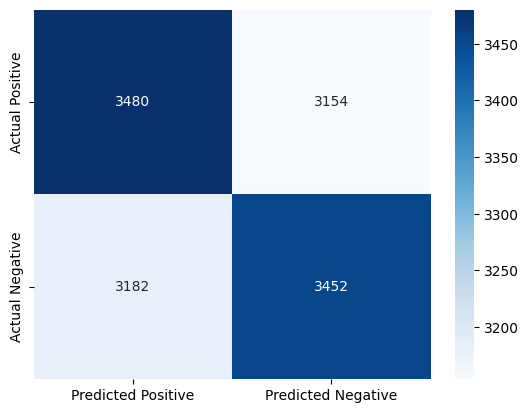

In [62]:
svc = SVC(kernel='rbf', C=0.8,random_state=RANDOM_SEED)
svc.fit(x_train,y_train)


print(classification_report(y_true=y_test, y_pred=svc.predict(x_test)))
plot_cm(y_test, svc.predict(x_test))

Like the naive bayes model, svm had a slight better result than the logistic regression, however, it can be the best model because due to rbf kernel, you do not have a higher importance of the features and therefore I could not give a reason to the customer. 

# Conclusion
I think the best model for this task it's the Random Forest Classifier which have an accuracy of 0.87 and a minor rate of False Posive respect the logistic regression (Precision on 0 = 0.93). 
Regard the "feature importance" the costumer can know that the credit card was issued due to: 
- years employed
- age
- count of family member
- occupation type